In [1]:
#!/usr/bin/env python3
#！_*_ coding:utf-8 _*_

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
# import shap
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold,KFold

from sklearn.metrics import mean_squared_error #MSE
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import r2_score           # R 2

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from pylab import mpl
import seaborn as sns 
import random 
import os 
import gc
from tqdm import tqdm 
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import label_binarize

mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus'] = False   

import warnings
warnings.filterwarnings('ignore')

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(123)

print('import finish')

import finish


### 1、读取数据

In [2]:
# Set global variables，result_set，used to store results for each model

result_set = pd.DataFrame()

# file path

DATA_PATH_ONS = '../data/ons-model-based-income-estimates-msoa (4).xls'
DATA_PATH_HOUSING = '../data/housing-density-borough (2).csv'
DATA_PATH_LOCAL = '../data/local_authority_traffic (5).csv'

# read data
data_ons_2011_12 = pd.read_excel(DATA_PATH_ONS,sheet_name='2011-12 (weekly income)')
data_ons_2013_14 = pd.read_excel(DATA_PATH_ONS,sheet_name='2013-14 (weekly income)')
data_ons_2015_16 = pd.read_excel(DATA_PATH_ONS,sheet_name='2015-16 (annual income)')

data_housing = pd.read_csv(DATA_PATH_HOUSING)
data_local = pd.read_csv(DATA_PATH_LOCAL)

In [3]:
data_ons_2011_12

,MSOA code,MSOA name,Local authority code,Local authority name,Region code,Region name,Total weekly income (£),Upper confidence limit (£),Lower confidence limit (£),Confidence interval (£),...,Lower confidence limit (£).1,Confidence interval (£).1,Net income before housing costs (£),Upper confidence limit (£).2,Lower confidence limit (£).2,Confidence interval (£).2,Net income after housing costs (£),Upper confidence limit (£).3,Lower confidence limit (£).3,Confidence interval (£).3
0,E02004297,County Durham 001,E06000047,County Durham,E12000001,North East,630,690,570,120,...,440,80,480,530,440,90,450,510,390,120
1,E02004290,County Durham 002,E06000047,County Durham,E12000001,North East,730,800,660,140,...,500,90,510,560,460,100,460,530,400,120
2,E02004298,County Durham 003,E06000047,County Durham,E12000001,North East,690,760,630,130,...,480,90,500,550,450,100,470,540,420,130
3,E02004299,County Durham 004,E06000047,County Durham,E12000001,North East,540,600,500,100,...,390,70,420,470,390,80,380,440,340,100
4,E02004291,County Durham 005,E06000047,County Durham,E12000001,North East,500,550,460,90,...,370,70,420,460,380,80,370,420,320,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7196,W02000362,Newport 016,W06000022,Newport,W92000004,Wales,810,900,730,180,...,550,120,570,630,510,120,520,600,450,150
7197,W02000363,Newport 017,W06000022,Newport,W92000004,Wales,540,600,480,120,...,390,80,440,490,400,90,400,460,350,110
7198,W02000364,Newport 018,W06000022,Newport,W92000004,Wales,440,480,390,90,...,330,70,340,380,310,70,250,290,220,70
7199,W02000365,Newport 019,W06000022,Newport,W92000004,Wales,550,610,500,110,...,400,80,410,460,370,80,340,390,300,100


In [4]:
data_ons_2013_14

,MSOA code,MSOA name,Local authority code,Local authority name,Region code,Region name,Total weekly income (£),Upper confidence limit (£),Lower confidence limit (£),Confidence interval (£),...,Lower confidence limit (£).1,Confidence interval (£).1,Net income before housing costs (£),Upper confidence limit (£).2,Lower confidence limit (£).2,Confidence interval (£).2,Net income after housing costs (£),Upper confidence limit (£).3,Lower confidence limit (£).3,Confidence interval (£).3
0,E02004297,County Durham 001,E06000047,County Durham,E12000001,North East,700,790,610,180,...,480,90,510,550,470,80,480,550,430,120
1,E02004290,County Durham 002,E06000047,County Durham,E12000001,North East,730,830,640,190,...,520,100,500,540,460,80,480,540,420,120
2,E02004298,County Durham 003,E06000047,County Durham,E12000001,North East,730,830,640,190,...,510,100,550,600,510,90,500,570,440,130
3,E02004299,County Durham 004,E06000047,County Durham,E12000001,North East,600,690,530,160,...,440,80,450,490,420,70,420,470,370,100
4,E02004291,County Durham 005,E06000047,County Durham,E12000001,North East,540,620,470,140,...,370,70,430,460,390,70,390,440,340,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7196,W02000362,Newport 016,W06000022,Newport,W92000004,Wales,720,820,630,190,...,510,100,510,560,470,90,470,540,420,120
7197,W02000363,Newport 017,W06000022,Newport,W92000004,Wales,570,650,500,150,...,410,80,420,460,390,70,400,460,360,100
7198,W02000364,Newport 018,W06000022,Newport,W92000004,Wales,460,520,400,130,...,330,80,330,360,300,60,260,300,230,70
7199,W02000365,Newport 019,W06000022,Newport,W92000004,Wales,540,610,470,140,...,390,70,390,420,360,60,340,390,300,90


In [5]:
data_ons_2015_16

,MSOA code,MSOA name,Local authority code,Local authority name,Region code,Region name,Total annual income (£),Upper confidence limit (£),Lower confidence limit (£),Confidence interval (£),...,Lower confidence limit (£).1,Confidence interval (£).1,Net income before housing costs (£),Upper confidence limit (£).2,Lower confidence limit (£).2,Confidence interval (£).2,Net income after housing costs (£),Upper confidence limit (£).3,Lower confidence limit (£).3,Confidence interval (£).3
0,E02004297,County Durham 001,E06000047,County Durham,E12000001,North East,35900,45200,28500,16700,...,22100,11700,27600,33300,22800,10400,25600,31000,21200,9800
1,E02004290,County Durham 002,E06000047,County Durham,E12000001,North East,42500,53600,33700,19900,...,23900,13100,28600,34500,23700,10800,27500,33200,22700,10500
2,E02004298,County Durham 003,E06000047,County Durham,E12000001,North East,38000,47700,30200,17600,...,22800,12300,28200,34100,23400,10700,26700,32300,22100,10200
3,E02004299,County Durham 004,E06000047,County Durham,E12000001,North East,33500,42200,26700,15500,...,21600,11200,25500,30800,21100,9700,22400,27100,18500,8700
4,E02004291,County Durham 005,E06000047,County Durham,E12000001,North East,31700,39800,25200,14600,...,20700,10800,25100,30200,20800,9500,20900,25300,17200,8000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7196,W02000362,Newport 016,W06000022,Newport,W92000004,Wales,38800,48800,30900,17900,...,24300,12600,27700,33400,23000,10500,26000,31400,21500,9800
7197,W02000363,Newport 017,W06000022,Newport,W92000004,Wales,32700,41200,26000,15100,...,20200,10400,25000,30200,20800,9400,22700,27400,18800,8600
7198,W02000364,Newport 018,W06000022,Newport,W92000004,Wales,25900,32800,20300,12500,...,17500,9300,20200,24400,16600,7800,16400,19800,13600,6300
7199,W02000365,Newport 019,W06000022,Newport,W92000004,Wales,32800,41400,26000,15400,...,20400,10700,24200,29200,20000,9200,19300,23400,16000,7400


In [6]:
# data concat

data_2011_2016 = pd.concat([data_ons_2011_12,data_ons_2013_14,data_ons_2015_16],axis = 0)
data_2011_2016

,MSOA code,MSOA name,Local authority code,Local authority name,Region code,Region name,Total weekly income (£),Upper confidence limit (£),Lower confidence limit (£),Confidence interval (£),...,Net income before housing costs (£),Upper confidence limit (£).2,Lower confidence limit (£).2,Confidence interval (£).2,Net income after housing costs (£),Upper confidence limit (£).3,Lower confidence limit (£).3,Confidence interval (£).3,Total annual income (£),Net annual income (£)
0,E02004297,County Durham 001,E06000047,County Durham,E12000001,North East,630.0,690,570,120,...,480,530,440,90,450,510,390,120,NaN,NaN
1,E02004290,County Durham 002,E06000047,County Durham,E12000001,North East,730.0,800,660,140,...,510,560,460,100,460,530,400,120,NaN,NaN
2,E02004298,County Durham 003,E06000047,County Durham,E12000001,North East,690.0,760,630,130,...,500,550,450,100,470,540,420,130,NaN,NaN
3,E02004299,County Durham 004,E06000047,County Durham,E12000001,North East,540.0,600,500,100,...,420,470,390,80,380,440,340,100,NaN,NaN
4,E02004291,County Durham 005,E06000047,County Durham,E12000001,North East,500.0,550,460,90,...,420,460,380,80,370,420,320,100,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7196,W02000362,Newport 016,W06000022,Newport,W92000004,Wales,NaN,48800,30900,17900,...,27700,33400,23000,10500,26000,31400,21500,9800,38800.0,29900.0
7197,W02000363,Newport 017,W06000022,Newport,W92000004,Wales,NaN,41200,26000,15100,...,25000,30200,20800,9400,22700,27400,18800,8600,32700.0,24900.0
7198,W02000364,Newport 018,W06000022,Newport,W92000004,Wales,NaN,32800,20300,12500,...,20200,24400,16600,7800,16400,19800,13600,6300,25900.0,21700.0
7199,W02000365,Newport 019,W06000022,Newport,W92000004,Wales,NaN,41400,26000,15400,...,24200,29200,20000,9200,19300,23400,16000,7400,32800.0,25200.0


In [7]:
data_housing

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre
0,E09000001,City of London,1999,ONS MYE,6581,290.4,314.9,22.7,2.9,2266.2
1,E09000001,City of London,2000,ONS MYE,7014,290.4,314.9,24.2,2.9,2415.3
2,E09000001,City of London,2001,ONS MYE,7359,290.4,314.9,25.3,2.9,2534.1
3,E09000001,City of London,2002,ONS MYE,7280,290.4,314.9,25.1,2.9,2506.9
4,E09000001,City of London,2003,ONS MYE,7115,290.4,314.9,24.5,2.9,2450.1
...,...,...,...,...,...,...,...,...,...,...
1867,E13000002,Outer London,2046,GLA Population Projections,6573194,125423.6,126675.6,52.4,1254.2,5240.8
1868,E13000002,Outer London,2047,GLA Population Projections,6598789,125423.6,126675.6,52.6,1254.2,5261.2
1869,E13000002,Outer London,2048,GLA Population Projections,6622921,125423.6,126675.6,52.8,1254.2,5280.4
1870,E13000002,Outer London,2049,GLA Population Projections,6647527,125423.6,126675.6,53.0,1254.2,5300.1


In [8]:
data_local

,id,local_authority_name,ons_code,region_id,local_authority_id,year,link_length_km,link_length_miles,cars_and_taxis,all_motor_vehicles
0,321,Hartlepool,E06000001,11,132,1993,385.351,239.45,287107346.8,3.422533e+08
1,822,Hartlepool,E06000001,11,132,1993,385.351,239.45,287107346.8,3.422533e+08
2,823,Middlesbrough,E06000002,11,170,1993,493.212,306.47,604140895.9,7.048122e+08
3,824,Redcar and Cleveland,E06000003,11,171,1993,675.168,419.53,446328948.9,5.228484e+08
4,825,Stockton-on-Tees,E06000004,11,163,1993,845.721,525.51,668148077.7,8.000379e+08
...,...,...,...,...,...,...,...,...,...,...
5730,6551,Torfaen,W06000020,4,25,2020,482.089,299.56,284507214.7,3.601668e+08
5731,6552,Monmouthshire,W06000021,4,13,2020,1626.520,1010.67,529506425.6,7.323918e+08
5732,6553,Newport,W06000022,4,6,2020,757.706,470.82,743499944.2,1.000086e+09
5733,6554,Powys,W06000023,4,14,2020,5357.025,3328.70,586677064.9,8.497405e+08


In [9]:
# cars_and_taxis，
# Population，
# Population_per_square_kilometre，
# Total_Area_Hectares，
# Total weekly income (£)， 
# Net income before housing costs (£)， 
# Net income after housing costs (£)

In [10]:
data_housing['cars_and_taxis'] = data_local['cars_and_taxis'] 
data_housing['Total weekly income (£)'] = data_ons_2011_12['Total weekly income (£)']
data_housing['Net income before housing costs (£)'] = data_ons_2011_12['Net income before housing costs (£)']
data_housing['Net income after housing costs (£)'] = data_ons_2011_12['Net income after housing costs (£)']

# label
data_housing['all_motor_vehicles'] = data_local['all_motor_vehicles']

In [11]:
data_local.isnull().sum()

id                      0
local_authority_name    0
ons_code                0
region_id               0
local_authority_id      0
year                    0
link_length_km          0
link_length_miles       0
cars_and_taxis          0
all_motor_vehicles      0
dtype: int64

In [12]:
data_housing

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre,cars_and_taxis,Total weekly income (£),Net income before housing costs (£),Net income after housing costs (£),all_motor_vehicles
0,E09000001,City of London,1999,ONS MYE,6581,290.4,314.9,22.7,2.9,2266.2,287107346.8,630,480,450,3.422533e+08
1,E09000001,City of London,2000,ONS MYE,7014,290.4,314.9,24.2,2.9,2415.3,287107346.8,730,510,460,3.422533e+08
2,E09000001,City of London,2001,ONS MYE,7359,290.4,314.9,25.3,2.9,2534.1,604140895.9,690,500,470,7.048122e+08
3,E09000001,City of London,2002,ONS MYE,7280,290.4,314.9,25.1,2.9,2506.9,446328948.9,540,420,380,5.228484e+08
4,E09000001,City of London,2003,ONS MYE,7115,290.4,314.9,24.5,2.9,2450.1,668148077.7,500,420,370,8.000379e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,E13000002,Outer London,2046,GLA Population Projections,6573194,125423.6,126675.6,52.4,1254.2,5240.8,856437997.9,630,470,410,1.055627e+09
1868,E13000002,Outer London,2047,GLA Population Projections,6598789,125423.6,126675.6,52.6,1254.2,5261.2,425162959.2,710,490,460,5.072792e+08
1869,E13000002,Outer London,2048,GLA Population Projections,6622921,125423.6,126675.6,52.8,1254.2,5280.4,356124062.4,540,400,360,4.169537e+08
1870,E13000002,Outer London,2049,GLA Population Projections,6647527,125423.6,126675.6,53.0,1254.2,5300.1,784174777.9,450,390,320,1.001045e+09


In [13]:
# copy

df = data_housing.copy()
df_rf = data_housing.copy()
df_mlp = data_housing.copy()
df_lgb = data_housing.copy()
df 

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre,cars_and_taxis,Total weekly income (£),Net income before housing costs (£),Net income after housing costs (£),all_motor_vehicles
0,E09000001,City of London,1999,ONS MYE,6581,290.4,314.9,22.7,2.9,2266.2,287107346.8,630,480,450,3.422533e+08
1,E09000001,City of London,2000,ONS MYE,7014,290.4,314.9,24.2,2.9,2415.3,287107346.8,730,510,460,3.422533e+08
2,E09000001,City of London,2001,ONS MYE,7359,290.4,314.9,25.3,2.9,2534.1,604140895.9,690,500,470,7.048122e+08
3,E09000001,City of London,2002,ONS MYE,7280,290.4,314.9,25.1,2.9,2506.9,446328948.9,540,420,380,5.228484e+08
4,E09000001,City of London,2003,ONS MYE,7115,290.4,314.9,24.5,2.9,2450.1,668148077.7,500,420,370,8.000379e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,E13000002,Outer London,2046,GLA Population Projections,6573194,125423.6,126675.6,52.4,1254.2,5240.8,856437997.9,630,470,410,1.055627e+09
1868,E13000002,Outer London,2047,GLA Population Projections,6598789,125423.6,126675.6,52.6,1254.2,5261.2,425162959.2,710,490,460,5.072792e+08
1869,E13000002,Outer London,2048,GLA Population Projections,6622921,125423.6,126675.6,52.8,1254.2,5280.4,356124062.4,540,400,360,4.169537e+08
1870,E13000002,Outer London,2049,GLA Population Projections,6647527,125423.6,126675.6,53.0,1254.2,5300.1,784174777.9,450,390,320,1.001045e+09


### 2、绘图 

In [14]:
plt.style.use("fivethirtyeight")
sns.set_style({'font.sans-serif': ['simhei', 'Arial']})

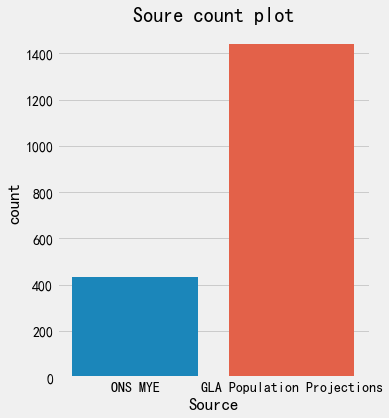

In [15]:
# soource plot 

plt.figure(figsize=(5,6))
plt.title('Soure count plot')
sns.countplot(df['Source'])
plt.show()

In [16]:
print('Proportion of missing values in each field:')
print(df.isnull().sum().sort_values(ascending=False) / df.shape[0])

Proportion of missing values in each field:
all_motor_vehicles                     0.0
Net income after housing costs (£)     0.0
Net income before housing costs (£)    0.0
Total weekly income (£)                0.0
cars_and_taxis                         0.0
Population_per_square_kilometre        0.0
Square_Kilometres                      0.0
Population_per_hectare                 0.0
Total_Area_Hectares                    0.0
Inland_Area _Hectares                  0.0
Population                             0.0
Source                                 0.0
Year                                   0.0
Name                                   0.0
Code                                   0.0
dtype: float64


Population


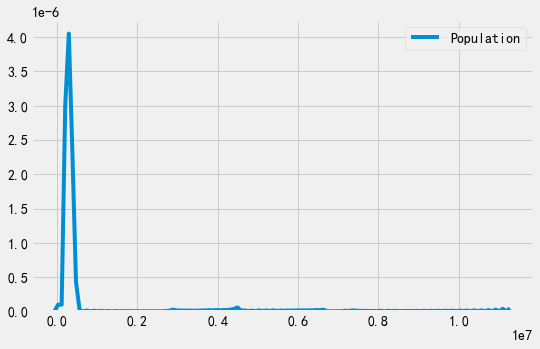

Inland_Area _Hectares


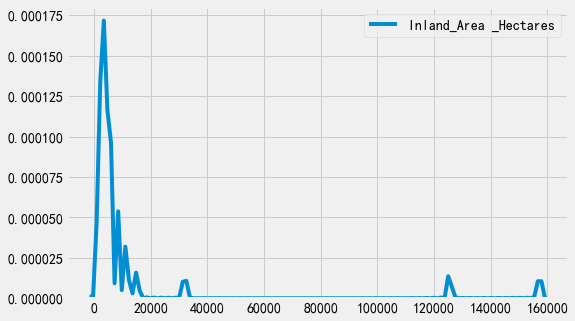

Total_Area_Hectares


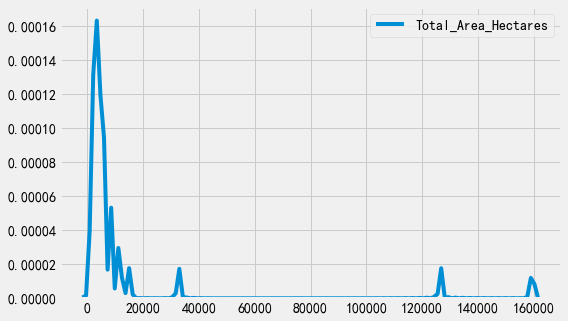

Population_per_hectare


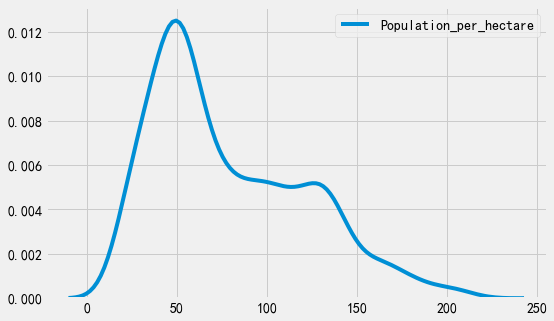

Square_Kilometres


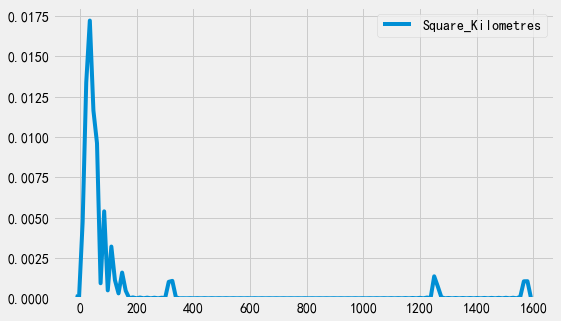

Population_per_square_kilometre


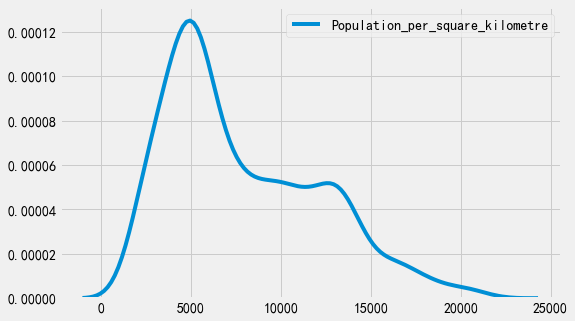

cars_and_taxis


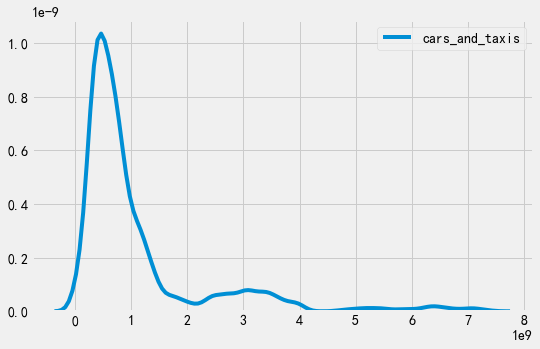

Total weekly income (£)


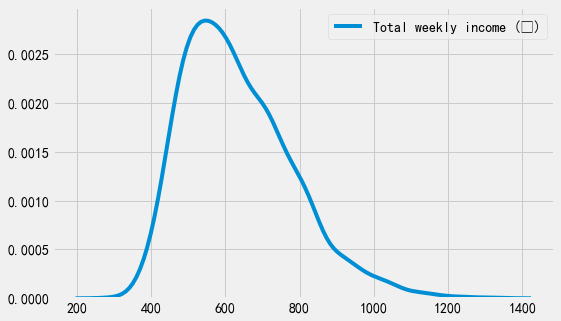

Net income before housing costs (£)


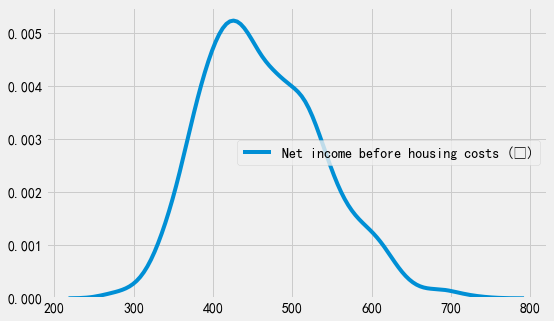

Net income after housing costs (£)


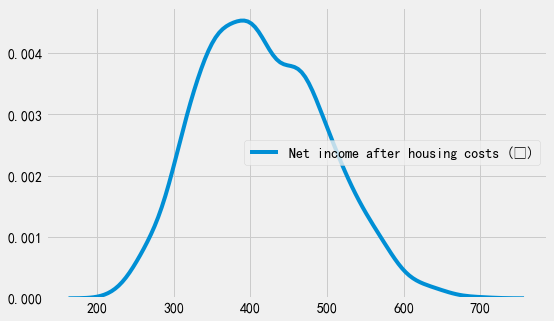

all_motor_vehicles


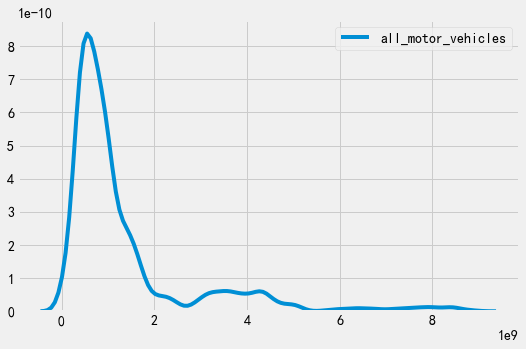

In [17]:
# set font 

plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

cols = [col for col in df.columns if col not in ['Code','Year','Name','Source']]


# Graph of kernel density for each field
for col in cols:
    print(col)
    plt.figure(figsize=(8,5))
    sns.kdeplot(df[col])
    plt.show()

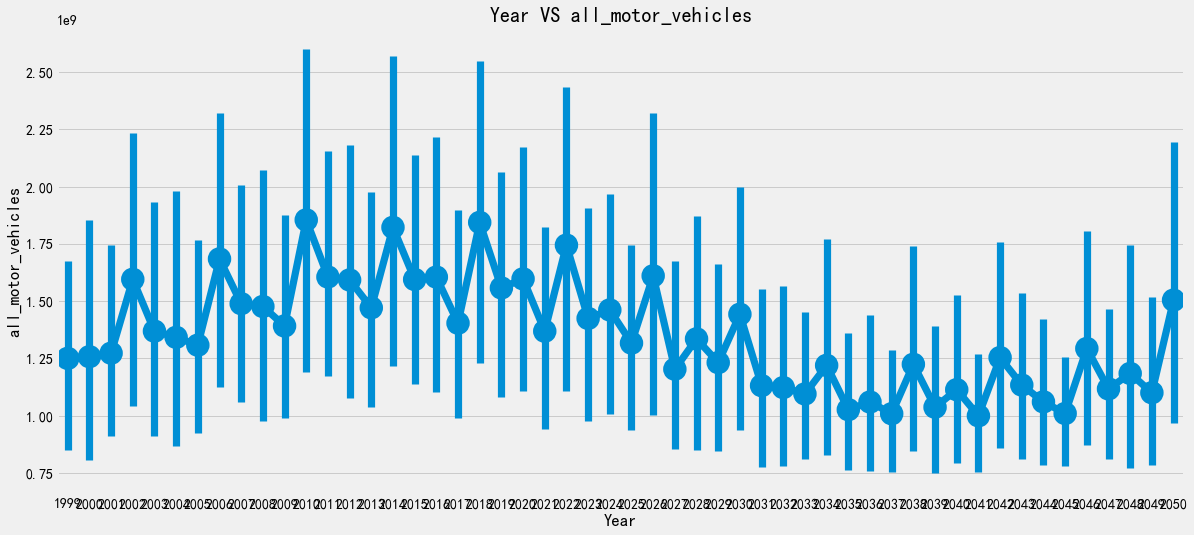

In [18]:
# Year VS all_motor_vehicles

plt.figure(figsize=(18,8))
plt.title('Year VS all_motor_vehicles')
sns.pointplot(x='Year', y='all_motor_vehicles', data=df)
plt.show()

In [19]:
# # Source 
# # ONS MYE ,GLA Population Projections

# plt.figure(figsize=(8,5))
# sns.lineplot(x='Year', y='all_motor_vehicles', data=df, hue='Source')
# plt.xticks(list(range(50)))
# plt.show()


plt.style.use("fivethirtyeight")
sns.set_style({'font.sans-serif': ['simhei', 'Arial']})

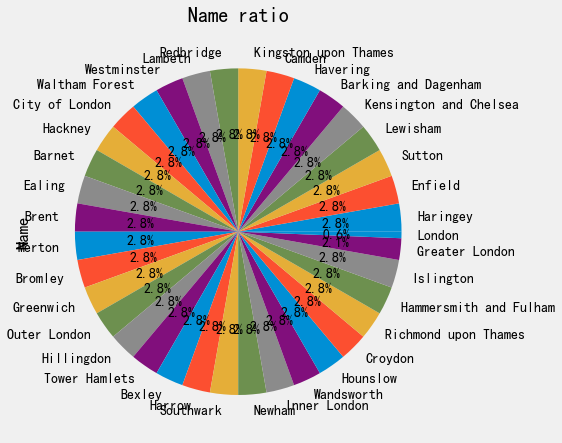

In [20]:
# Name plot 

plt.figure(figsize=[9, 7])
plt.title('Name ratio')
df['Name'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

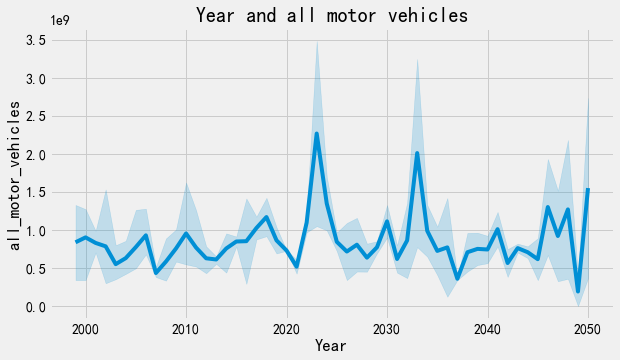

In [21]:
## all_motor_vehicles plot

plt.figure(figsize=(9, 5)) 
plt.title('Year and all motor vehicles')
sns.lineplot(data = df[:120],x = df['Year'][:120],y = df['all_motor_vehicles'][:120])
plt.show()

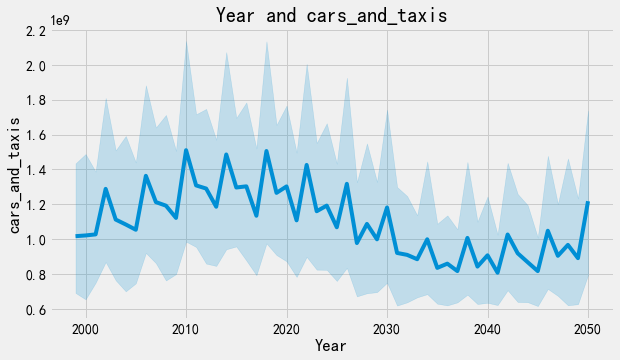

In [22]:
## cars_and_taxis plot

plt.figure(figsize=(9, 5)) 
plt.title('Year and cars_and_taxis')
sns.lineplot(data = df,x = df['Year'],y = df['cars_and_taxis'])
plt.show()

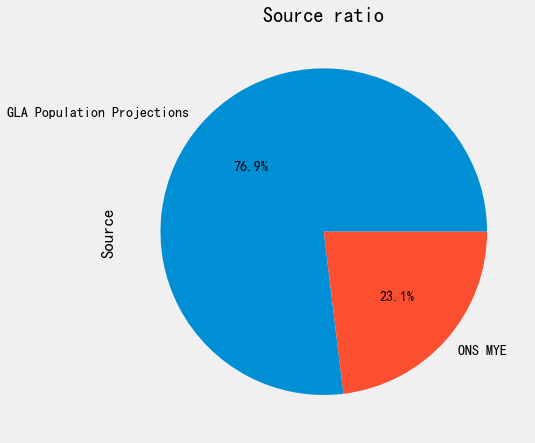

In [23]:
# Source ratio plot 

plt.figure(figsize=[9, 7])
plt.title('Source ratio')
df['Source'].value_counts().plot.pie(autopct='%1.1f%%')
plt.show()

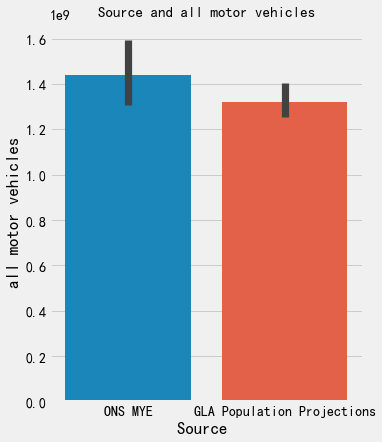

In [24]:
# Source  VS  all_motor_vehicles plot 

f, ax3 = plt.subplots(figsize=(5, 6.5))
sns.barplot(x='Source', y='all_motor_vehicles', data=df, ax=ax3)
ax3.set_title('Source and all motor vehicles', fontsize=15)
ax3.set_xlabel('Source ')
ax3.set_ylabel('all motor vehicles')
plt.show()

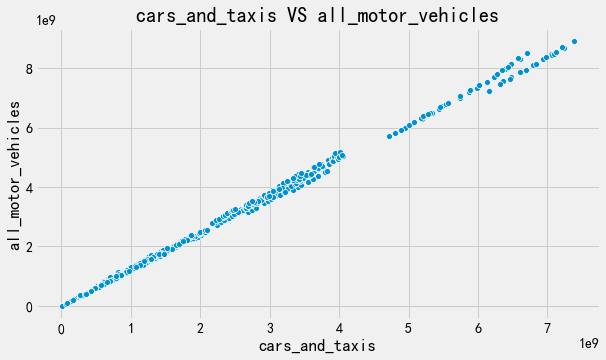

In [25]:
# cars_and_taxis VS  all_motor_vehicles plot 

plt.figure(figsize=(9, 5)) 
plt.title('cars_and_taxis VS all_motor_vehicles')
sns.scatterplot(data = df,x = df['cars_and_taxis'],y = df['all_motor_vehicles'])
plt.show()

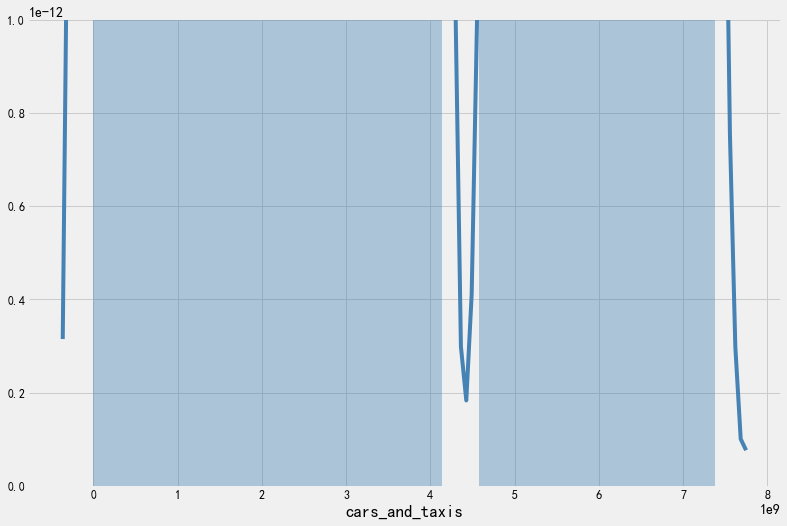

In [26]:
# cars_and_taxis frequency histogram

plt.figure(figsize=(12, 8))  # Set the size of the canvas
# sns.set_palette("hls")       
sns.distplot(df['cars_and_taxis'],color="steelblue",bins=50,kde = True)
plt.grid(linestyle='-')   # Add grid lines
plt.xticks(fontsize=12)   # Change the x font size
plt.yticks(fontsize=12)   # Change the y font size
sns.despine(ax=None, top=True, right=True, left=True,bottom=True)    
plt.show()

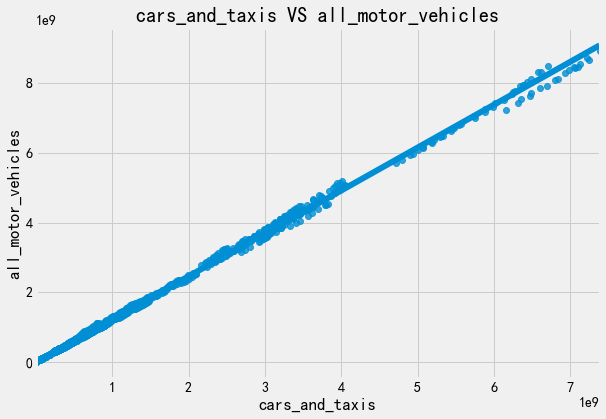

In [27]:
# cars_and_taxis VS all_motor_vehicles

plt.figure(figsize=(9, 6))
plt.title("cars_and_taxis VS all_motor_vehicles")
sns.regplot(df['cars_and_taxis'],df['all_motor_vehicles'])
plt.show()

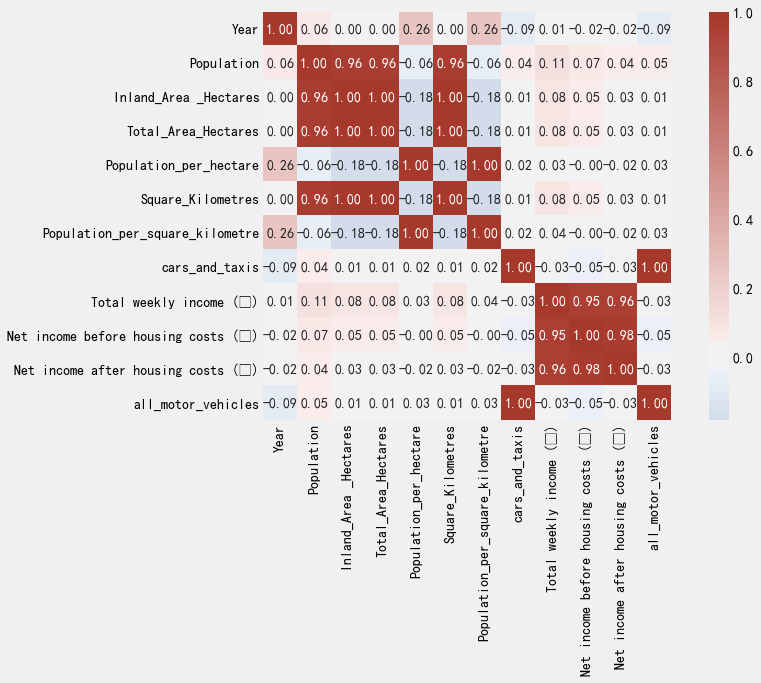

In [28]:
# Draw a correlation matrix to see the correlation coefficients between fields. 
# The larger the value, the more relevant it is.

matrix = df.corr()
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
plt.figure(figsize=(12, 7))
sns.heatmap(matrix, center=0, annot=True, fmt='.2f', square=True, cmap=cmap)
plt.show()

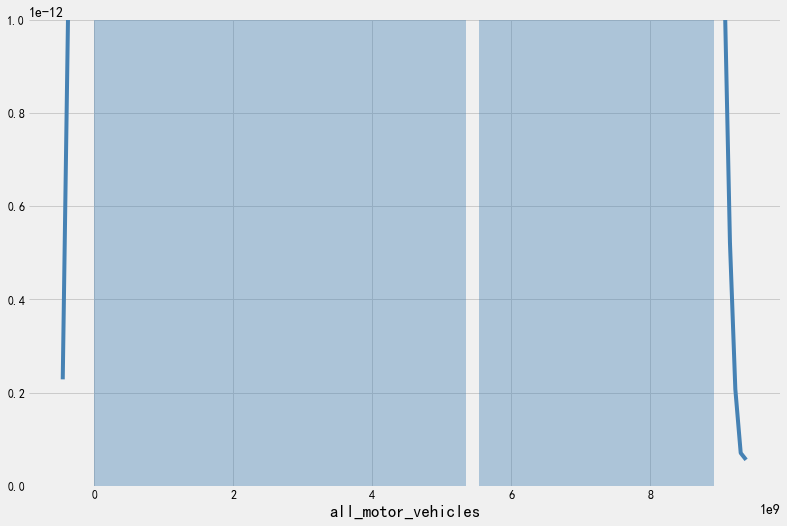

In [29]:
plt.figure(figsize=(12, 8))  # Set the size of the canvas
# sns.set_palette("hls")       
sns.distplot(df['all_motor_vehicles'],color="steelblue",bins=50,kde = True)
plt.grid(linestyle='-')   # Add grid lines
plt.xticks(fontsize=12)   # Change the x font size
plt.yticks(fontsize=12)   # Change the y font size
sns.despine(ax=None, top=True, right=True, left=True,bottom=True)    
plt.show()


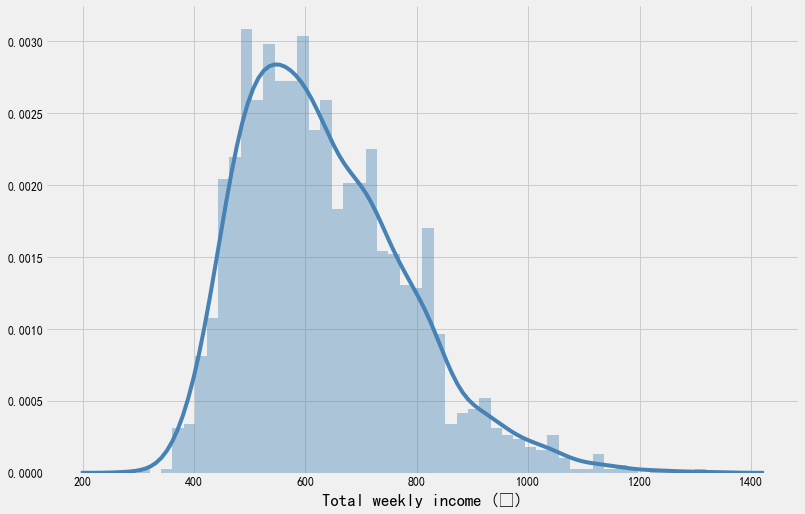

In [30]:
plt.figure(figsize=(12, 8))  # Set the size of the canvas
# sns.set_palette("hls")       
sns.distplot(df['Total weekly income (£)'],color="steelblue",bins=50,kde = True)
plt.grid(linestyle='-')   # Add grid lines
plt.xticks(fontsize=12)   # Change the x font size
plt.yticks(fontsize=12)   # Change the y font size
sns.despine(ax=None, top=True, right=True, left=True,bottom=True)    
plt.show()

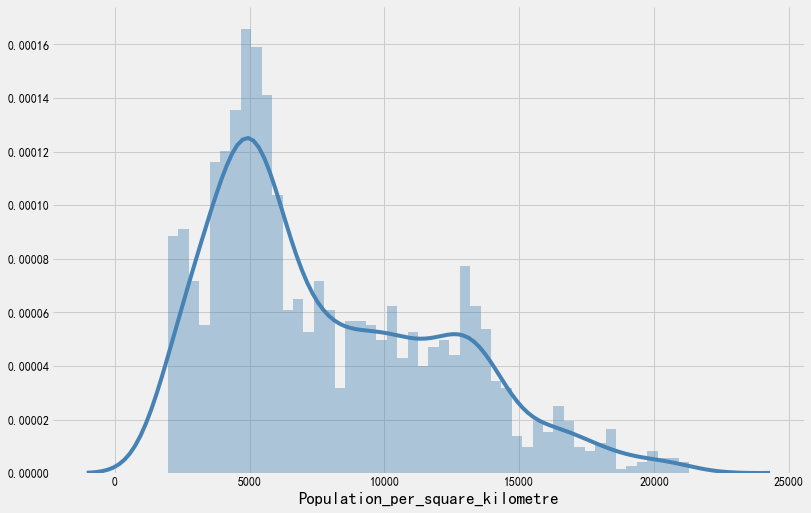

In [31]:
plt.figure(figsize=(12, 8))  # Set the size of the canvas
# sns.set_palette("hls")       
sns.distplot(df['Population_per_square_kilometre'],color="steelblue",bins=50,kde = True)
plt.grid(linestyle='-')   # Add grid lines
plt.xticks(fontsize=12)   # Change the x font size
plt.yticks(fontsize=12)   # Change the y font size
sns.despine(ax=None, top=True, right=True, left=True,bottom=True)    
plt.show()

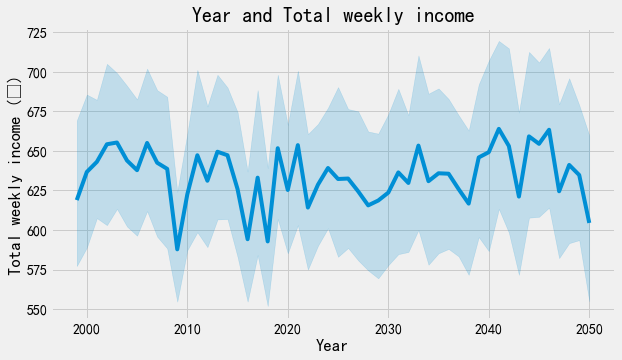

In [32]:
## Total weekly income plot

plt.figure(figsize=(9, 5)) 
plt.title('Year and Total weekly income')
plt.ylabel('Total weekly income')
sns.lineplot(data = df,x = df['Year'],y = df['Total weekly income (£)'])
plt.show()

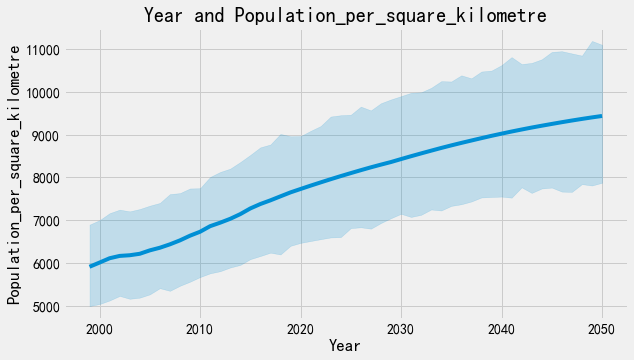

In [33]:
## Population_per_square_kilometre plot

plt.figure(figsize=(9, 5)) 
plt.title('Year and Population_per_square_kilometre')
sns.lineplot(data = df,x = df['Year'],y = df['Population_per_square_kilometre'])
plt.show()

### 3、建立模型 

In [34]:
# label encoding

LE = LabelEncoder()
df['Name'] = LE.fit_transform(df['Name'])
df['Source'] = LE.fit_transform(df['Source'])
df['Code'] = LE.fit_transform(df['Code'])
df 

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre,cars_and_taxis,Total weekly income (£),Net income before housing costs (£),Net income after housing costs (£),all_motor_vehicles
0,0,6,1999,1,6581,290.4,314.9,22.7,2.9,2266.2,287107346.8,630,480,450,3.422533e+08
1,0,6,2000,1,7014,290.4,314.9,24.2,2.9,2415.3,287107346.8,730,510,460,3.422533e+08
2,0,6,2001,1,7359,290.4,314.9,25.3,2.9,2534.1,604140895.9,690,500,470,7.048122e+08
3,0,6,2002,1,7280,290.4,314.9,25.1,2.9,2506.9,446328948.9,540,420,380,5.228484e+08
4,0,6,2003,1,7115,290.4,314.9,24.5,2.9,2450.1,668148077.7,500,420,370,8.000379e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,35,28,2046,0,6573194,125423.6,126675.6,52.4,1254.2,5240.8,856437997.9,630,470,410,1.055627e+09
1868,35,28,2047,0,6598789,125423.6,126675.6,52.6,1254.2,5261.2,425162959.2,710,490,460,5.072792e+08
1869,35,28,2048,0,6622921,125423.6,126675.6,52.8,1254.2,5280.4,356124062.4,540,400,360,4.169537e+08
1870,35,28,2049,0,6647527,125423.6,126675.6,53.0,1254.2,5300.1,784174777.9,450,390,320,1.001045e+09


In [35]:
df.columns

Index(['Code', 'Name', 'Year', 'Source', 'Population', 'Inland_Area _Hectares',
       'Total_Area_Hectares', 'Population_per_hectare', 'Square_Kilometres',
       'Population_per_square_kilometre', 'cars_and_taxis',
       'Total weekly income (£)', 'Net income before housing costs (£)',
       'Net income after housing costs (£)', 'all_motor_vehicles'],
      dtype='object')

In [36]:
# log transformation
def logs(all,colunms):
    for col in colunms:
        all[col] = np.log(all[col]+1)
    return all


# square transformation
def squ(res,ls):
    m = res.shape[1]
    for i in ls:
        res = res.assign(newcol = pd.Series((res[i]*res[i]).values))
        res.columns.values[m] = i + '_squ'
        m+=1 
    return res 

log_features = ['Inland_Area _Hectares']

squ_features = ['Population_per_hectare']

df = squ(df,squ_features)
df = logs(df,log_features)
df

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre,cars_and_taxis,Total weekly income (£),Net income before housing costs (£),Net income after housing costs (£),all_motor_vehicles,Population_per_hectare_squ
0,0,6,1999,1,6581,5.674697,314.9,22.7,2.9,2266.2,287107346.8,630,480,450,3.422533e+08,515.29
1,0,6,2000,1,7014,5.674697,314.9,24.2,2.9,2415.3,287107346.8,730,510,460,3.422533e+08,585.64
2,0,6,2001,1,7359,5.674697,314.9,25.3,2.9,2534.1,604140895.9,690,500,470,7.048122e+08,640.09
3,0,6,2002,1,7280,5.674697,314.9,25.1,2.9,2506.9,446328948.9,540,420,380,5.228484e+08,630.01
4,0,6,2003,1,7115,5.674697,314.9,24.5,2.9,2450.1,668148077.7,500,420,370,8.000379e+08,600.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,35,28,2046,0,6573194,11.739460,126675.6,52.4,1254.2,5240.8,856437997.9,630,470,410,1.055627e+09,2745.76
1868,35,28,2047,0,6598789,11.739460,126675.6,52.6,1254.2,5261.2,425162959.2,710,490,460,5.072792e+08,2766.76
1869,35,28,2048,0,6622921,11.739460,126675.6,52.8,1254.2,5280.4,356124062.4,540,400,360,4.169537e+08,2787.84
1870,35,28,2049,0,6647527,11.739460,126675.6,53.0,1254.2,5300.1,784174777.9,450,390,320,1.001045e+09,2809.00


In [37]:
# Data normalization

features = [fea for fea in df.columns if fea not in ['all_motor_vehicles']]
scaler = MinMaxScaler(feature_range=(0, 1))

for f in features:
    df[f] = scaler.fit_transform(df[f].values.reshape(-1,1))
df 

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre,cars_and_taxis,Total weekly income (£),Net income before housing costs (£),Net income after housing costs (£),all_motor_vehicles,Population_per_hectare_squ
0,0.0,0.166667,0.000000,1.0,0.000000,0.000000,0.000000,0.016037,0.000000,0.015623,0.038759,0.323529,0.446809,0.479167,3.422533e+08,0.002918
1,0.0,0.166667,0.019608,1.0,0.000039,0.000000,0.000000,0.023797,0.000000,0.023337,0.038759,0.421569,0.510638,0.500000,3.422533e+08,0.004483
2,0.0,0.166667,0.039216,1.0,0.000069,0.000000,0.000000,0.029488,0.000000,0.029483,0.081696,0.382353,0.489362,0.520833,7.048122e+08,0.005695
3,0.0,0.166667,0.058824,1.0,0.000062,0.000000,0.000000,0.028453,0.000000,0.028075,0.060323,0.235294,0.319149,0.333333,5.228484e+08,0.005470
4,0.0,0.166667,0.078431,1.0,0.000048,0.000000,0.000000,0.025349,0.000000,0.025137,0.090365,0.196078,0.319149,0.312500,8.000379e+08,0.004808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,1.0,0.777778,0.921569,0.0,0.586218,0.964087,0.793944,0.169684,0.797413,0.169508,0.115866,0.323529,0.425532,0.395833,1.055627e+09,0.052547
1868,1.0,0.777778,0.941176,0.0,0.588502,0.964087,0.793944,0.170719,0.797413,0.170563,0.057457,0.401961,0.468085,0.500000,5.072792e+08,0.053015
1869,1.0,0.777778,0.960784,0.0,0.590657,0.964087,0.793944,0.171754,0.797413,0.171556,0.048107,0.235294,0.276596,0.291667,4.169537e+08,0.053484
1870,1.0,0.777778,0.980392,0.0,0.592853,0.964087,0.793944,0.172788,0.797413,0.172575,0.106079,0.147059,0.255319,0.208333,1.001045e+09,0.053955


In [38]:
df = df.fillna(df.mean())
df 

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre,cars_and_taxis,Total weekly income (£),Net income before housing costs (£),Net income after housing costs (£),all_motor_vehicles,Population_per_hectare_squ
0,0.0,0.166667,0.000000,1.0,0.000000,0.000000,0.000000,0.016037,0.000000,0.015623,0.038759,0.323529,0.446809,0.479167,3.422533e+08,0.002918
1,0.0,0.166667,0.019608,1.0,0.000039,0.000000,0.000000,0.023797,0.000000,0.023337,0.038759,0.421569,0.510638,0.500000,3.422533e+08,0.004483
2,0.0,0.166667,0.039216,1.0,0.000069,0.000000,0.000000,0.029488,0.000000,0.029483,0.081696,0.382353,0.489362,0.520833,7.048122e+08,0.005695
3,0.0,0.166667,0.058824,1.0,0.000062,0.000000,0.000000,0.028453,0.000000,0.028075,0.060323,0.235294,0.319149,0.333333,5.228484e+08,0.005470
4,0.0,0.166667,0.078431,1.0,0.000048,0.000000,0.000000,0.025349,0.000000,0.025137,0.090365,0.196078,0.319149,0.312500,8.000379e+08,0.004808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,1.0,0.777778,0.921569,0.0,0.586218,0.964087,0.793944,0.169684,0.797413,0.169508,0.115866,0.323529,0.425532,0.395833,1.055627e+09,0.052547
1868,1.0,0.777778,0.941176,0.0,0.588502,0.964087,0.793944,0.170719,0.797413,0.170563,0.057457,0.401961,0.468085,0.500000,5.072792e+08,0.053015
1869,1.0,0.777778,0.960784,0.0,0.590657,0.964087,0.793944,0.171754,0.797413,0.171556,0.048107,0.235294,0.276596,0.291667,4.169537e+08,0.053484
1870,1.0,0.777778,0.980392,0.0,0.592853,0.964087,0.793944,0.172788,0.797413,0.172575,0.106079,0.147059,0.255319,0.208333,1.001045e+09,0.053955


In [39]:
# Partition dataset

data = df.drop(columns=[
                        'all_motor_vehicles'
                       ])

label = df['all_motor_vehicles']

test_size = 0.2
random_state = 2022 
x_trian,x_test,y_train,y_test = train_test_split(data,
                                                 label,
                                                 test_size = test_size,
                                                 shuffle = False,
                                                 random_state = random_state
                                                )


In [40]:
# linear regression

from sklearn.linear_model import LinearRegression 
LR = LinearRegression(fit_intercept=True,
                      normalize=False,
                      copy_X=True,
                      n_jobs=-2,
                     )

LR = LR.fit(x_trian,y_train)

In [41]:
# test model mean_squared_error   mean_absolute_error

pred = LR.predict(x_test)
mse = mean_squared_error(pred,y_test)
mae = mean_absolute_error(pred,y_test)
r2 = r2_score(pred,y_test)
print('LinearRegression r2:',round(r2,5))
print('LinearRegression mse:',round(mse,5))
print('LinearRegression mae:',round(mae,5))

LinearRegression r2: 0.99362
LinearRegression mse: 1.7112202263014676e+16
LinearRegression mae: 90970410.76056


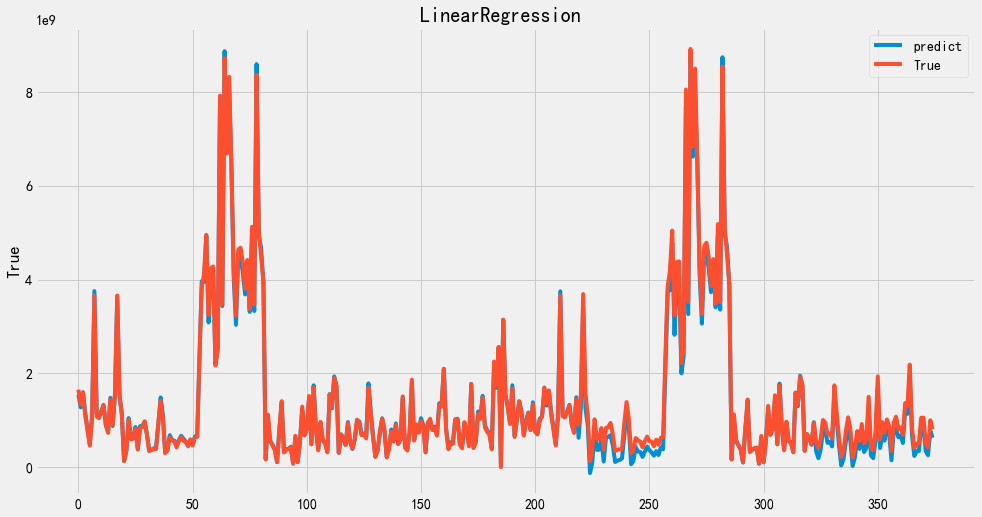

In [42]:
# comparison of results  

x_test['predict'] = pred 
x_test['True'] = y_test

# store
result_set['LRresult'] = pred

plt.figure(figsize=(15,8)) 
plt.title('LinearRegression ')
sns.lineplot(data = x_test,x = range(375),y = x_test['predict'],label = 'predict')
sns.lineplot(data = x_test,x = range(375),y = x_test['True'],label = 'True')
plt.legend(loc='best')
plt.show()

In [43]:
df_rf

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre,cars_and_taxis,Total weekly income (£),Net income before housing costs (£),Net income after housing costs (£),all_motor_vehicles
0,E09000001,City of London,1999,ONS MYE,6581,290.4,314.9,22.7,2.9,2266.2,287107346.8,630,480,450,3.422533e+08
1,E09000001,City of London,2000,ONS MYE,7014,290.4,314.9,24.2,2.9,2415.3,287107346.8,730,510,460,3.422533e+08
2,E09000001,City of London,2001,ONS MYE,7359,290.4,314.9,25.3,2.9,2534.1,604140895.9,690,500,470,7.048122e+08
3,E09000001,City of London,2002,ONS MYE,7280,290.4,314.9,25.1,2.9,2506.9,446328948.9,540,420,380,5.228484e+08
4,E09000001,City of London,2003,ONS MYE,7115,290.4,314.9,24.5,2.9,2450.1,668148077.7,500,420,370,8.000379e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,E13000002,Outer London,2046,GLA Population Projections,6573194,125423.6,126675.6,52.4,1254.2,5240.8,856437997.9,630,470,410,1.055627e+09
1868,E13000002,Outer London,2047,GLA Population Projections,6598789,125423.6,126675.6,52.6,1254.2,5261.2,425162959.2,710,490,460,5.072792e+08
1869,E13000002,Outer London,2048,GLA Population Projections,6622921,125423.6,126675.6,52.8,1254.2,5280.4,356124062.4,540,400,360,4.169537e+08
1870,E13000002,Outer London,2049,GLA Population Projections,6647527,125423.6,126675.6,53.0,1254.2,5300.1,784174777.9,450,390,320,1.001045e+09


In [44]:
# label encoding  

LE = LabelEncoder()
df_rf['Name'] = LE.fit_transform(df_rf['Name'])
df_rf['Source'] = LE.fit_transform(df_rf['Source'])
df_rf['Code'] = LE.fit_transform(df_rf['Code'])
df_rf 

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre,cars_and_taxis,Total weekly income (£),Net income before housing costs (£),Net income after housing costs (£),all_motor_vehicles
0,0,6,1999,1,6581,290.4,314.9,22.7,2.9,2266.2,287107346.8,630,480,450,3.422533e+08
1,0,6,2000,1,7014,290.4,314.9,24.2,2.9,2415.3,287107346.8,730,510,460,3.422533e+08
2,0,6,2001,1,7359,290.4,314.9,25.3,2.9,2534.1,604140895.9,690,500,470,7.048122e+08
3,0,6,2002,1,7280,290.4,314.9,25.1,2.9,2506.9,446328948.9,540,420,380,5.228484e+08
4,0,6,2003,1,7115,290.4,314.9,24.5,2.9,2450.1,668148077.7,500,420,370,8.000379e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,35,28,2046,0,6573194,125423.6,126675.6,52.4,1254.2,5240.8,856437997.9,630,470,410,1.055627e+09
1868,35,28,2047,0,6598789,125423.6,126675.6,52.6,1254.2,5261.2,425162959.2,710,490,460,5.072792e+08
1869,35,28,2048,0,6622921,125423.6,126675.6,52.8,1254.2,5280.4,356124062.4,540,400,360,4.169537e+08
1870,35,28,2049,0,6647527,125423.6,126675.6,53.0,1254.2,5300.1,784174777.9,450,390,320,1.001045e+09


In [45]:
# log transformation
def logs(all,colunms):
    for col in colunms:
        all[col] = np.log(all[col]+1)
    return all


# square transformation
def squ(res,ls):
    m = res.shape[1]
    for i in ls:
        res = res.assign(newcol = pd.Series((res[i]*res[i]).values))
        res.columns.values[m] = i + '_squ'
        m+=1 
    return res 

log_features = ['Inland_Area _Hectares']

squ_features = ['Population_per_hectare',]

df_rf = squ(df_rf,squ_features)
df_rf = logs(df_rf,log_features)
df_rf

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre,cars_and_taxis,Total weekly income (£),Net income before housing costs (£),Net income after housing costs (£),all_motor_vehicles,Population_per_hectare_squ
0,0,6,1999,1,6581,5.674697,314.9,22.7,2.9,2266.2,287107346.8,630,480,450,3.422533e+08,515.29
1,0,6,2000,1,7014,5.674697,314.9,24.2,2.9,2415.3,287107346.8,730,510,460,3.422533e+08,585.64
2,0,6,2001,1,7359,5.674697,314.9,25.3,2.9,2534.1,604140895.9,690,500,470,7.048122e+08,640.09
3,0,6,2002,1,7280,5.674697,314.9,25.1,2.9,2506.9,446328948.9,540,420,380,5.228484e+08,630.01
4,0,6,2003,1,7115,5.674697,314.9,24.5,2.9,2450.1,668148077.7,500,420,370,8.000379e+08,600.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,35,28,2046,0,6573194,11.739460,126675.6,52.4,1254.2,5240.8,856437997.9,630,470,410,1.055627e+09,2745.76
1868,35,28,2047,0,6598789,11.739460,126675.6,52.6,1254.2,5261.2,425162959.2,710,490,460,5.072792e+08,2766.76
1869,35,28,2048,0,6622921,11.739460,126675.6,52.8,1254.2,5280.4,356124062.4,540,400,360,4.169537e+08,2787.84
1870,35,28,2049,0,6647527,11.739460,126675.6,53.0,1254.2,5300.1,784174777.9,450,390,320,1.001045e+09,2809.00


In [46]:
# Partition dataset

data = df_rf.drop(columns=[
                        'all_motor_vehicles'
                           ])

label = df_rf['all_motor_vehicles']

test_size = 0.2
random_state = 2022 
x_trian,x_test,y_train,y_test = train_test_split(data,
                                                 label,
                                                 test_size = test_size,
                                                 shuffle = False,
                                                 random_state = random_state
                                                )


In [47]:
# Random Forest

randomforest = RandomForestRegressor(n_estimators=500,
                                        max_depth=10,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
#                                         min_impurity_split=None,
                                        bootstrap=True,
                                        oob_score=False,
                                        n_jobs=None,
                                        random_state=None,
                                        verbose=0,
                                        warm_start=False,
                                        ccp_alpha=0.0,
                                        max_samples=None,
                                     )

randomforest = randomforest.fit(x_trian,y_train)



In [48]:
# test model

# x_test = x_test.drop(columns=['predict','True'])
pred = randomforest.predict(x_test)
mse = mean_squared_error(pred,y_test)
mae = mean_absolute_error(pred,y_test)
r2 = r2_score(pred,y_test)
print('RandomForest  r2:',round(r2,5))
print('RandomForest  mse:',round(mse,5))
print('RandomForest  mae:',round(mae,5))


RandomForest  r2: 0.99806
RandomForest  mse: 5043895833873043.0
RandomForest  mae: 37799700.61883


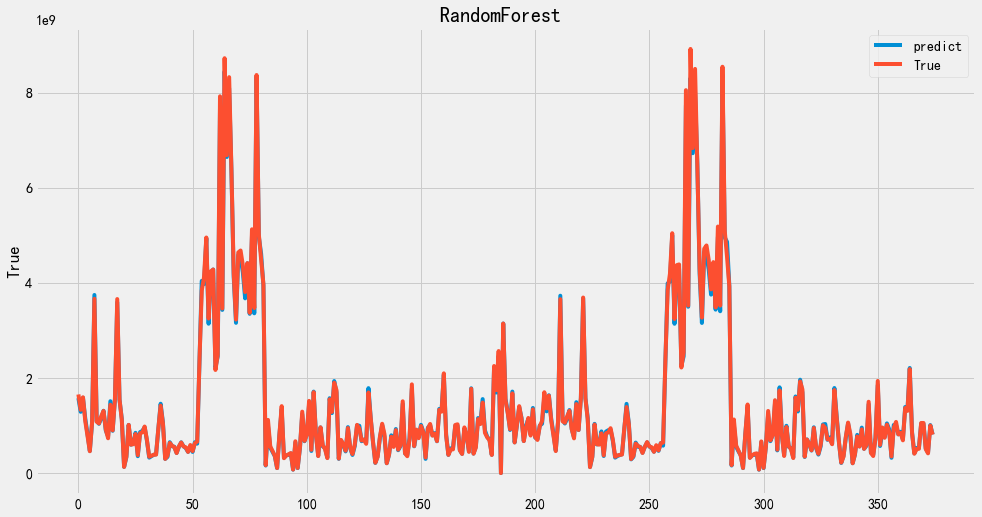

In [49]:
# comparison of results

x_test['predict'] = pred 
x_test['True'] = y_test

# store
result_set['RFresult'] = pred

plt.figure(figsize=(15,8)) 
plt.title('RandomForest ')
sns.lineplot(data = x_test,x = range(375),y = x_test['predict'],label = 'predict')
sns.lineplot(data = x_test,x = range(375),y = x_test['True'],label = 'True')
plt.legend(loc='best')
plt.show()

In [50]:
df_mlp

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre,cars_and_taxis,Total weekly income (£),Net income before housing costs (£),Net income after housing costs (£),all_motor_vehicles
0,E09000001,City of London,1999,ONS MYE,6581,290.4,314.9,22.7,2.9,2266.2,287107346.8,630,480,450,3.422533e+08
1,E09000001,City of London,2000,ONS MYE,7014,290.4,314.9,24.2,2.9,2415.3,287107346.8,730,510,460,3.422533e+08
2,E09000001,City of London,2001,ONS MYE,7359,290.4,314.9,25.3,2.9,2534.1,604140895.9,690,500,470,7.048122e+08
3,E09000001,City of London,2002,ONS MYE,7280,290.4,314.9,25.1,2.9,2506.9,446328948.9,540,420,380,5.228484e+08
4,E09000001,City of London,2003,ONS MYE,7115,290.4,314.9,24.5,2.9,2450.1,668148077.7,500,420,370,8.000379e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,E13000002,Outer London,2046,GLA Population Projections,6573194,125423.6,126675.6,52.4,1254.2,5240.8,856437997.9,630,470,410,1.055627e+09
1868,E13000002,Outer London,2047,GLA Population Projections,6598789,125423.6,126675.6,52.6,1254.2,5261.2,425162959.2,710,490,460,5.072792e+08
1869,E13000002,Outer London,2048,GLA Population Projections,6622921,125423.6,126675.6,52.8,1254.2,5280.4,356124062.4,540,400,360,4.169537e+08
1870,E13000002,Outer London,2049,GLA Population Projections,6647527,125423.6,126675.6,53.0,1254.2,5300.1,784174777.9,450,390,320,1.001045e+09


In [51]:
# label encoding

LE = LabelEncoder()
df_mlp['Name'] = LE.fit_transform(df_mlp['Name'])
df_mlp['Source'] = LE.fit_transform(df_mlp['Source'])
df_mlp['Code'] = LE.fit_transform(df_mlp['Code'])
df_mlp 

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre,cars_and_taxis,Total weekly income (£),Net income before housing costs (£),Net income after housing costs (£),all_motor_vehicles
0,0,6,1999,1,6581,290.4,314.9,22.7,2.9,2266.2,287107346.8,630,480,450,3.422533e+08
1,0,6,2000,1,7014,290.4,314.9,24.2,2.9,2415.3,287107346.8,730,510,460,3.422533e+08
2,0,6,2001,1,7359,290.4,314.9,25.3,2.9,2534.1,604140895.9,690,500,470,7.048122e+08
3,0,6,2002,1,7280,290.4,314.9,25.1,2.9,2506.9,446328948.9,540,420,380,5.228484e+08
4,0,6,2003,1,7115,290.4,314.9,24.5,2.9,2450.1,668148077.7,500,420,370,8.000379e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,35,28,2046,0,6573194,125423.6,126675.6,52.4,1254.2,5240.8,856437997.9,630,470,410,1.055627e+09
1868,35,28,2047,0,6598789,125423.6,126675.6,52.6,1254.2,5261.2,425162959.2,710,490,460,5.072792e+08
1869,35,28,2048,0,6622921,125423.6,126675.6,52.8,1254.2,5280.4,356124062.4,540,400,360,4.169537e+08
1870,35,28,2049,0,6647527,125423.6,126675.6,53.0,1254.2,5300.1,784174777.9,450,390,320,1.001045e+09


In [52]:
# log transformation
def logs(all,colunms):
    for col in colunms:
        all[col] = np.log(all[col]+1)
    return all


# square transformation
def squ(res,ls):
    m = res.shape[1]
    for i in ls:
        res = res.assign(newcol = pd.Series((res[i]*res[i]).values))
        res.columns.values[m] = i + '_squ'
        m+=1 
    return res 

log_features = ['Inland_Area _Hectares']

squ_features = ['Population_per_hectare',]

df_mlp = squ(df_mlp,squ_features)
df_mlp = logs(df_mlp,log_features)
df_mlp

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre,cars_and_taxis,Total weekly income (£),Net income before housing costs (£),Net income after housing costs (£),all_motor_vehicles,Population_per_hectare_squ
0,0,6,1999,1,6581,5.674697,314.9,22.7,2.9,2266.2,287107346.8,630,480,450,3.422533e+08,515.29
1,0,6,2000,1,7014,5.674697,314.9,24.2,2.9,2415.3,287107346.8,730,510,460,3.422533e+08,585.64
2,0,6,2001,1,7359,5.674697,314.9,25.3,2.9,2534.1,604140895.9,690,500,470,7.048122e+08,640.09
3,0,6,2002,1,7280,5.674697,314.9,25.1,2.9,2506.9,446328948.9,540,420,380,5.228484e+08,630.01
4,0,6,2003,1,7115,5.674697,314.9,24.5,2.9,2450.1,668148077.7,500,420,370,8.000379e+08,600.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,35,28,2046,0,6573194,11.739460,126675.6,52.4,1254.2,5240.8,856437997.9,630,470,410,1.055627e+09,2745.76
1868,35,28,2047,0,6598789,11.739460,126675.6,52.6,1254.2,5261.2,425162959.2,710,490,460,5.072792e+08,2766.76
1869,35,28,2048,0,6622921,11.739460,126675.6,52.8,1254.2,5280.4,356124062.4,540,400,360,4.169537e+08,2787.84
1870,35,28,2049,0,6647527,11.739460,126675.6,53.0,1254.2,5300.1,784174777.9,450,390,320,1.001045e+09,2809.00


In [53]:
# Partition dataset

data = df_mlp.drop(columns=[
                        'all_motor_vehicles'
                           ])

label = df_mlp['all_motor_vehicles']

test_size = 0.2
random_state = 2022 
x_trian,x_test,y_train,y_test = train_test_split(data,
                                                 label,
                                                 test_size = test_size,
                                                 shuffle = False,
                                                 random_state = random_state
                                                )


In [54]:
# MLP 

from sklearn.neural_network import MLPRegressor
MLP = MLPRegressor(
                    hidden_layer_sizes=(100,50),
                    activation='relu',
                    solver='adam',
                    alpha=0.001,
                    batch_size='auto',
                    learning_rate='constant',
                    learning_rate_init=0.001,
                    power_t=0.5,
                    max_iter=500,
                    shuffle=True,
                    random_state=None,
                    tol=0.0001,
                    verbose=False,
                    warm_start=False,
                    momentum=0.9,
                    nesterovs_momentum=True,
                    early_stopping=False,
                    validation_fraction=0.1,
                    beta_1=0.9,
                    beta_2=0.999,
                    epsilon=1e-08,
                    n_iter_no_change=10,
                    max_fun=15000,
                    )

    
MLP.fit(x_trian,y_train)


MLPRegressor(alpha=0.001, hidden_layer_sizes=(100, 50), max_iter=500)

In [55]:
# text model

# x_test = x_test.drop(columns=['predict','True'])
pred = MLP.predict(x_test)

In [56]:
# compute R2 
mse = mean_squared_error(pred,y_test)
mae = mean_absolute_error(pred,y_test)
r2 = r2_score(pred,y_test)
print('MLP r2:',round(r2,5))
print('MLP mse:',round(mse,5))
print('MLP mae:',round(mae,5))

MLP r2: 0.99844
MLP mse: 4158194416418189.5
MLP mae: 39045052.39669


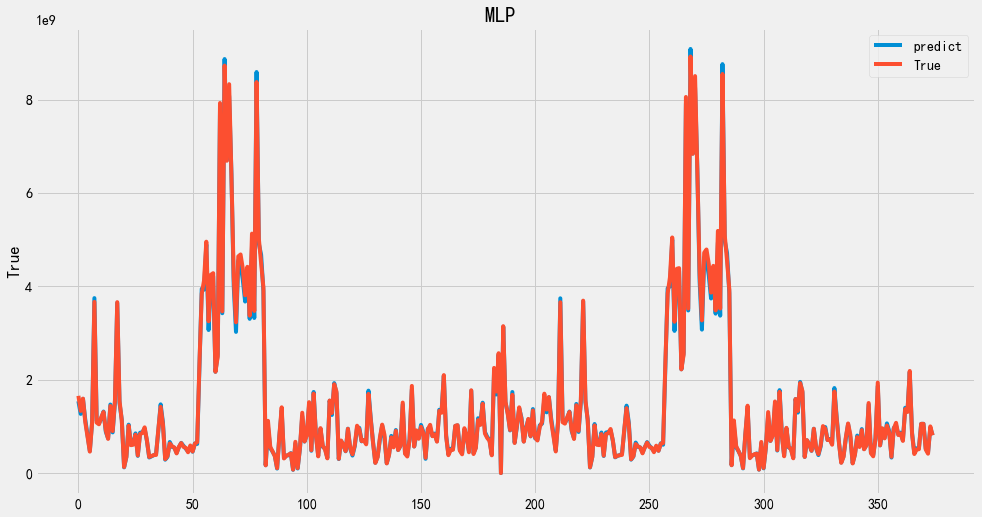

In [57]:
# comparison of results

x_test['predict'] = pred 
x_test['True'] = y_test

# store
result_set['MLPresult'] = pred

plt.figure(figsize=(15,8)) 
plt.title('MLP ')
sns.lineplot(data = x_test,x = range(375),y = x_test['predict'],label = 'predict')
sns.lineplot(data = x_test,x = range(375),y = x_test['True'],label = 'True')
plt.legend(loc='best')
plt.show()

In [58]:
# df_lgb.shape[0] * 0.7

In [59]:
df_lgb

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre,cars_and_taxis,Total weekly income (£),Net income before housing costs (£),Net income after housing costs (£),all_motor_vehicles
0,E09000001,City of London,1999,ONS MYE,6581,290.4,314.9,22.7,2.9,2266.2,287107346.8,630,480,450,3.422533e+08
1,E09000001,City of London,2000,ONS MYE,7014,290.4,314.9,24.2,2.9,2415.3,287107346.8,730,510,460,3.422533e+08
2,E09000001,City of London,2001,ONS MYE,7359,290.4,314.9,25.3,2.9,2534.1,604140895.9,690,500,470,7.048122e+08
3,E09000001,City of London,2002,ONS MYE,7280,290.4,314.9,25.1,2.9,2506.9,446328948.9,540,420,380,5.228484e+08
4,E09000001,City of London,2003,ONS MYE,7115,290.4,314.9,24.5,2.9,2450.1,668148077.7,500,420,370,8.000379e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,E13000002,Outer London,2046,GLA Population Projections,6573194,125423.6,126675.6,52.4,1254.2,5240.8,856437997.9,630,470,410,1.055627e+09
1868,E13000002,Outer London,2047,GLA Population Projections,6598789,125423.6,126675.6,52.6,1254.2,5261.2,425162959.2,710,490,460,5.072792e+08
1869,E13000002,Outer London,2048,GLA Population Projections,6622921,125423.6,126675.6,52.8,1254.2,5280.4,356124062.4,540,400,360,4.169537e+08
1870,E13000002,Outer London,2049,GLA Population Projections,6647527,125423.6,126675.6,53.0,1254.2,5300.1,784174777.9,450,390,320,1.001045e+09


In [60]:
# label encoding

LE = LabelEncoder()
df_lgb['Name'] = LE.fit_transform(df_lgb['Name'])
df_lgb['Source'] = LE.fit_transform(df_lgb['Source'])
df_lgb['Code'] = LE.fit_transform(df_lgb['Code'])
df_lgb 

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre,cars_and_taxis,Total weekly income (£),Net income before housing costs (£),Net income after housing costs (£),all_motor_vehicles
0,0,6,1999,1,6581,290.4,314.9,22.7,2.9,2266.2,287107346.8,630,480,450,3.422533e+08
1,0,6,2000,1,7014,290.4,314.9,24.2,2.9,2415.3,287107346.8,730,510,460,3.422533e+08
2,0,6,2001,1,7359,290.4,314.9,25.3,2.9,2534.1,604140895.9,690,500,470,7.048122e+08
3,0,6,2002,1,7280,290.4,314.9,25.1,2.9,2506.9,446328948.9,540,420,380,5.228484e+08
4,0,6,2003,1,7115,290.4,314.9,24.5,2.9,2450.1,668148077.7,500,420,370,8.000379e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,35,28,2046,0,6573194,125423.6,126675.6,52.4,1254.2,5240.8,856437997.9,630,470,410,1.055627e+09
1868,35,28,2047,0,6598789,125423.6,126675.6,52.6,1254.2,5261.2,425162959.2,710,490,460,5.072792e+08
1869,35,28,2048,0,6622921,125423.6,126675.6,52.8,1254.2,5280.4,356124062.4,540,400,360,4.169537e+08
1870,35,28,2049,0,6647527,125423.6,126675.6,53.0,1254.2,5300.1,784174777.9,450,390,320,1.001045e+09


In [61]:
# log transformation
def logs(all,colunms):
    for col in colunms:
        all[col] = np.log(all[col]+1)
    return all


# square transformation
def squ(res,ls):
    m = res.shape[1]
    for i in ls:
        res = res.assign(newcol = pd.Series((res[i]*res[i]).values))
        res.columns.values[m] = i + '_squ'
        m+=1 
    return res 

log_features = ['Inland_Area _Hectares',
                'Population',
                'Total_Area_Hectares',
                'cars_and_taxis'
               ]

squ_features = ['Population_per_hectare','Square_Kilometres']

df_lgb = squ(df_lgb,squ_features)
df_lgb = logs(df_lgb,log_features)
df_lgb

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre,cars_and_taxis,Total weekly income (£),Net income before housing costs (£),Net income after housing costs (£),all_motor_vehicles,Population_per_hectare_squ,Square_Kilometres_squ
0,0,6,1999,1,8.792094,5.674697,5.755426,22.7,2.9,2266.2,19.475367,630,480,450,3.422533e+08,515.29,8.41
1,0,6,2000,1,8.855806,5.674697,5.755426,24.2,2.9,2415.3,19.475367,730,510,460,3.422533e+08,585.64,8.41
2,0,6,2001,1,8.903815,5.674697,5.755426,25.3,2.9,2534.1,20.219318,690,500,470,7.048122e+08,640.09,8.41
3,0,6,2002,1,8.893023,5.674697,5.755426,25.1,2.9,2506.9,19.916567,540,420,380,5.228484e+08,630.01,8.41
4,0,6,2003,1,8.870101,5.674697,5.755426,24.5,2.9,2450.1,20.320020,500,420,370,8.000379e+08,600.25,8.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,35,28,2046,0,15.698511,11.739460,11.749393,52.4,1254.2,5240.8,20.568292,630,470,410,1.055627e+09,2745.76,1573017.64
1868,35,28,2047,0,15.702397,11.739460,11.749393,52.6,1254.2,5261.2,19.867983,710,490,460,5.072792e+08,2766.76,1573017.64
1869,35,28,2048,0,15.706047,11.739460,11.749393,52.8,1254.2,5280.4,19.690790,540,400,360,4.169537e+08,2787.84,1573017.64
1870,35,28,2049,0,15.709756,11.739460,11.749393,53.0,1254.2,5300.1,20.480142,450,390,320,1.001045e+09,2809.00,1573017.64


In [62]:

train_len = df_lgb.shape[0] * 0.7
train_len = int(np.round(train_len))

test_len = df_lgb.shape[0] * 0.3
test_len = int(np.round(test_len))


train = df_lgb[:train_len]
test = df_lgb[-test_len:]

In [63]:
train

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre,cars_and_taxis,Total weekly income (£),Net income before housing costs (£),Net income after housing costs (£),all_motor_vehicles,Population_per_hectare_squ,Square_Kilometres_squ
0,0,6,1999,1,8.792094,5.674697,5.755426,22.7,2.9,2266.2,19.475367,630,480,450,3.422533e+08,515.29,8.41
1,0,6,2000,1,8.855806,5.674697,5.755426,24.2,2.9,2415.3,19.475367,730,510,460,3.422533e+08,585.64,8.41
2,0,6,2001,1,8.903815,5.674697,5.755426,25.3,2.9,2534.1,20.219318,690,500,470,7.048122e+08,640.09,8.41
3,0,6,2002,1,8.893023,5.674697,5.755426,25.1,2.9,2506.9,19.916567,540,420,380,5.228484e+08,630.01,8.41
4,0,6,2003,1,8.870101,5.674697,5.755426,24.5,2.9,2450.1,20.320020,500,420,370,8.000379e+08,600.25,8.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,25,29,2004,1,12.424304,8.638153,8.638561,44.1,56.4,4409.4,20.394926,750,510,460,9.118165e+08,1944.81,3180.96
1306,25,29,2005,1,12.435441,8.638153,8.638561,44.6,56.4,4458.8,20.246174,570,460,410,7.485562e+08,1989.16,3180.96
1307,25,29,2006,1,12.451334,8.638153,8.638561,45.3,56.4,4530.2,20.908152,640,410,380,1.446260e+09,2052.09,3180.96
1308,25,29,2007,1,12.468306,8.638153,8.638561,46.1,56.4,4607.8,20.381907,460,360,310,9.009401e+08,2125.21,3180.96


In [64]:
test

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre,cars_and_taxis,Total weekly income (£),Net income before housing costs (£),Net income after housing costs (£),all_motor_vehicles,Population_per_hectare_squ,Square_Kilometres_squ
1310,25,29,2009,1,12.507791,8.638153,8.638561,47.9,56.4,4793.3,21.808131,480,360,330,3.649334e+09,2294.41,3180.96
1311,25,29,2010,1,12.524850,8.638153,8.638561,48.8,56.4,4875.8,20.928277,650,480,450,1.567029e+09,2381.44,3180.96
1312,25,29,2011,0,12.547966,8.638153,8.638561,49.9,56.4,4989.8,20.676372,640,460,410,1.151078e+09,2490.01,3180.96
1313,25,29,2012,0,12.559346,8.638153,8.638561,50.5,56.4,5046.9,18.456803,630,480,430,1.344135e+08,2550.25,3180.96
1314,25,29,2013,0,12.572100,8.638153,8.638561,51.1,56.4,5111.7,19.473986,450,360,310,3.569087e+08,2611.21,3180.96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,35,28,2046,0,15.698511,11.739460,11.749393,52.4,1254.2,5240.8,20.568292,630,470,410,1.055627e+09,2745.76,1573017.64
1868,35,28,2047,0,15.702397,11.739460,11.749393,52.6,1254.2,5261.2,19.867983,710,490,460,5.072792e+08,2766.76,1573017.64
1869,35,28,2048,0,15.706047,11.739460,11.749393,52.8,1254.2,5280.4,19.690790,540,400,360,4.169537e+08,2787.84,1573017.64
1870,35,28,2049,0,15.709756,11.739460,11.749393,53.0,1254.2,5300.1,20.480142,450,390,320,1.001045e+09,2809.00,1573017.64


In [65]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
folds = KFold(n_splits=5,shuffle=True,random_state=2022)

for col in train.columns:
    colname = col+'_kfold'
    for fold_,(trn_idx,val_idx) in enumerate(folds.split(train,train)):
        tmp = train.iloc[trn_idx]
        order_label = tmp.groupby([col])['all_motor_vehicles'].mean()
        train[colname] = train[col].map(order_label)
#     order_label = train.groupby([col])['attack_cat'].mean()
#     test[colname] = test[col].map(order_label)

    

for col in test.columns:
    colname = col+'_kfold'
    for fold_,(trn_idx,val_idx) in enumerate(folds.split(test,test)):
        tmp = test.iloc[trn_idx]
        order_label = tmp.groupby([col])['all_motor_vehicles'].mean()
        test[colname] = test[col].map(order_label)
# order_label = train.groupby([col])['attack_cat'].mean()
# test[colname] = test[col].map(order_label)
train

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre,...,Population_per_hectare_kfold,Square_Kilometres_kfold,Population_per_square_kilometre_kfold,cars_and_taxis_kfold,Total weekly income (£)_kfold,Net income before housing costs (£)_kfold,Net income after housing costs (£)_kfold,all_motor_vehicles_kfold,Population_per_hectare_squ_kfold,Square_Kilometres_squ_kfold
0,0,6,1999,1,8.792094,5.674697,5.755426,22.7,2.9,2266.2,...,3.422533e+08,7.799561e+08,3.422533e+08,3.422533e+08,1.796123e+09,1.301948e+09,1.446952e+09,3.422533e+08,3.422533e+08,7.799561e+08
1,0,6,2000,1,8.855806,5.674697,5.755426,24.2,2.9,2415.3,...,6.651892e+08,7.799561e+08,3.422533e+08,3.422533e+08,1.063439e+09,1.066477e+09,1.255162e+09,3.422533e+08,6.651892e+08,7.799561e+08
2,0,6,2001,1,8.903815,5.674697,5.755426,25.3,2.9,2534.1,...,7.048122e+08,7.799561e+08,7.048122e+08,7.048122e+08,1.037074e+09,1.177602e+09,1.126191e+09,7.048122e+08,7.048122e+08,7.799561e+08
3,0,6,2002,1,8.893023,5.674697,5.755426,25.1,2.9,2506.9,...,5.083171e+08,7.799561e+08,5.228484e+08,5.228484e+08,1.228188e+09,1.570837e+09,1.466671e+09,5.228484e+08,5.083171e+08,7.799561e+08
4,0,6,2003,1,8.870101,5.674697,5.755426,24.5,2.9,2450.1,...,6.120514e+08,7.799561e+08,8.000379e+08,8.000379e+08,1.147286e+09,1.570837e+09,1.567109e+09,8.000379e+08,6.120514e+08,7.799561e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,25,29,2004,1,12.424304,8.638153,8.638561,44.1,56.4,4409.4,...,9.118165e+08,1.170419e+09,9.118165e+08,9.118165e+08,1.603948e+09,1.066477e+09,1.255162e+09,9.118165e+08,9.118165e+08,1.170419e+09
1306,25,29,2005,1,12.435441,8.638153,8.638561,44.6,56.4,4458.8,...,6.941136e+08,1.170419e+09,7.485562e+08,7.485562e+08,1.644007e+09,2.155762e+09,1.747438e+09,7.485562e+08,6.941136e+08,1.170419e+09
1307,25,29,2006,1,12.451334,8.638153,8.638561,45.3,56.4,4530.2,...,8.057532e+08,1.170419e+09,1.446260e+09,1.446260e+09,1.518602e+09,1.107489e+09,1.466671e+09,1.446260e+09,8.057532e+08,1.170419e+09
1308,25,29,2007,1,12.468306,8.638153,8.638561,46.1,56.4,4607.8,...,9.528976e+08,1.170419e+09,NaN,NaN,1.169991e+09,9.834076e+08,9.289662e+08,NaN,9.528976e+08,1.170419e+09


In [66]:
test

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre,...,Population_per_hectare_kfold,Square_Kilometres_kfold,Population_per_square_kilometre_kfold,cars_and_taxis_kfold,Total weekly income (£)_kfold,Net income before housing costs (£)_kfold,Net income after housing costs (£)_kfold,all_motor_vehicles_kfold,Population_per_hectare_squ_kfold,Square_Kilometres_squ_kfold
1310,25,29,2009,1,12.507791,8.638153,8.638561,47.9,56.4,4793.3,...,3.649334e+09,1.165136e+09,3.649334e+09,3.649334e+09,1.751668e+09,2.255468e+09,1.314542e+09,3.649334e+09,3.649334e+09,1.165136e+09
1311,25,29,2010,1,12.524850,8.638153,8.638561,48.8,56.4,4875.8,...,1.567029e+09,1.165136e+09,1.567029e+09,1.567029e+09,2.057215e+09,1.627940e+09,1.766005e+09,1.567029e+09,1.567029e+09,1.165136e+09
1312,25,29,2011,0,12.547966,8.638153,8.638561,49.9,56.4,4989.8,...,1.151078e+09,1.165136e+09,1.151078e+09,1.151078e+09,1.833965e+09,1.636019e+09,1.652139e+09,1.151078e+09,1.151078e+09,1.165136e+09
1313,25,29,2012,0,12.559346,8.638153,8.638561,50.5,56.4,5046.9,...,8.013069e+08,1.165136e+09,1.344135e+08,1.344135e+08,2.275587e+09,1.627940e+09,2.578978e+09,1.344135e+08,8.013069e+08,1.165136e+09
1314,25,29,2013,0,12.572100,8.638153,8.638561,51.1,56.4,5111.7,...,3.569087e+08,1.165136e+09,3.569087e+08,3.569087e+08,8.940828e+08,2.255468e+09,1.246398e+09,3.569087e+08,3.569087e+08,1.165136e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,35,28,2046,0,15.698511,11.739460,11.749393,52.4,1254.2,5240.8,...,NaN,8.690640e+08,NaN,NaN,2.275587e+09,2.121869e+09,1.652139e+09,NaN,NaN,8.690640e+08
1868,35,28,2047,0,15.702397,11.739460,11.749393,52.6,1254.2,5261.2,...,6.190913e+08,8.690640e+08,5.072792e+08,5.072792e+08,1.029787e+09,1.705609e+09,1.674865e+09,5.072792e+08,6.190913e+08,8.690640e+08
1869,35,28,2048,0,15.706047,11.739460,11.749393,52.8,1254.2,5280.4,...,4.169537e+08,8.690640e+08,4.169537e+08,4.169537e+08,1.578010e+09,2.820529e+09,1.676632e+09,4.169537e+08,4.169537e+08,8.690640e+08
1870,35,28,2049,0,15.709756,11.739460,11.749393,53.0,1254.2,5300.1,...,8.487382e+08,8.690640e+08,1.001045e+09,1.001045e+09,8.940828e+08,1.324031e+09,1.651162e+09,1.001045e+09,8.487382e+08,8.690640e+08


In [67]:
# data concat

df_lgb = pd.concat([train,test], axis = 0)
df_lgb 

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre,...,Population_per_hectare_kfold,Square_Kilometres_kfold,Population_per_square_kilometre_kfold,cars_and_taxis_kfold,Total weekly income (£)_kfold,Net income before housing costs (£)_kfold,Net income after housing costs (£)_kfold,all_motor_vehicles_kfold,Population_per_hectare_squ_kfold,Square_Kilometres_squ_kfold
0,0,6,1999,1,8.792094,5.674697,5.755426,22.7,2.9,2266.2,...,3.422533e+08,7.799561e+08,3.422533e+08,3.422533e+08,1.796123e+09,1.301948e+09,1.446952e+09,3.422533e+08,3.422533e+08,7.799561e+08
1,0,6,2000,1,8.855806,5.674697,5.755426,24.2,2.9,2415.3,...,6.651892e+08,7.799561e+08,3.422533e+08,3.422533e+08,1.063439e+09,1.066477e+09,1.255162e+09,3.422533e+08,6.651892e+08,7.799561e+08
2,0,6,2001,1,8.903815,5.674697,5.755426,25.3,2.9,2534.1,...,7.048122e+08,7.799561e+08,7.048122e+08,7.048122e+08,1.037074e+09,1.177602e+09,1.126191e+09,7.048122e+08,7.048122e+08,7.799561e+08
3,0,6,2002,1,8.893023,5.674697,5.755426,25.1,2.9,2506.9,...,5.083171e+08,7.799561e+08,5.228484e+08,5.228484e+08,1.228188e+09,1.570837e+09,1.466671e+09,5.228484e+08,5.083171e+08,7.799561e+08
4,0,6,2003,1,8.870101,5.674697,5.755426,24.5,2.9,2450.1,...,6.120514e+08,7.799561e+08,8.000379e+08,8.000379e+08,1.147286e+09,1.570837e+09,1.567109e+09,8.000379e+08,6.120514e+08,7.799561e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1867,35,28,2046,0,15.698511,11.739460,11.749393,52.4,1254.2,5240.8,...,NaN,8.690640e+08,NaN,NaN,2.275587e+09,2.121869e+09,1.652139e+09,NaN,NaN,8.690640e+08
1868,35,28,2047,0,15.702397,11.739460,11.749393,52.6,1254.2,5261.2,...,6.190913e+08,8.690640e+08,5.072792e+08,5.072792e+08,1.029787e+09,1.705609e+09,1.674865e+09,5.072792e+08,6.190913e+08,8.690640e+08
1869,35,28,2048,0,15.706047,11.739460,11.749393,52.8,1254.2,5280.4,...,4.169537e+08,8.690640e+08,4.169537e+08,4.169537e+08,1.578010e+09,2.820529e+09,1.676632e+09,4.169537e+08,4.169537e+08,8.690640e+08
1870,35,28,2049,0,15.709756,11.739460,11.749393,53.0,1254.2,5300.1,...,8.487382e+08,8.690640e+08,1.001045e+09,1.001045e+09,8.940828e+08,1.324031e+09,1.651162e+09,1.001045e+09,8.487382e+08,8.690640e+08


In [68]:
# LGB 

# Partition dataset

data = df_lgb.drop(columns=[
                        'all_motor_vehicles'
                           ])

label = df_lgb['all_motor_vehicles']

test_size = 0.2
random_state = 2022 
x_train,x_test,y_train,y_test = train_test_split(data,
                                                 label,
                                                 test_size = test_size,
                                                 shuffle = False,
                                                 random_state = random_state
                                                )




In [69]:
# LGB

import lightgbm as lgb 
DEBUG = False                              # Debug mode can run code quickly, non-debug mode can get better results
num_boost_round = 20 if DEBUG else 500
n_estimators = 5 if DEBUG else 100
NFOLD = 5 
random_state = 2022 

lgb = lgb.LGBMRegressor()


In [70]:
%%time 

import warnings
warnings.filterwarnings('ignore')
param_search = {
               'n_estimators':range(100,500,100),
               'eta':np.arange(0.02,0.2,0.1),
               'max_depth':range(30,34,1),
#                'num_leaves':range(10,30,10),
#                'min_child_weight':range(300,1500,500),
            }

model = GridSearchCV(lgb, param_search, cv = 5)
model = model.fit(x_train, y_train)


[LightGBM] [Warning] learning_rate is set=0.1, eta=0.02 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.02 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.02 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.02 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.02 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.02 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.02 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.02 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.02 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1,

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.02 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.02 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.12000000000000001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.12000000000000001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.12000000000000001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.12000000000000001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.12000000000000001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.12000000000000001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.120000000

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.12000000000000001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.12000000000000001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.12000000000000001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.12000000000000001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.12000000000000001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.12000000000000001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.12000000000000001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.12000000000000001 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_ra

In [71]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [72]:
%%time 

# test model

# x_test = x_test.drop(columns=['predict','True'])
pred = model.predict(x_test)

# compute R2 
mse = mean_squared_error(pred,y_test)
mae = mean_absolute_error(pred,y_test)
r2 = r2_score(pred,y_test)
print('LGB r2:',round(r2,5))
print('LGB mse:',round(mse,5))
print('LGB mae:',round(mae,5))


LGB r2: 0.99854
LGB mse: 3943465492643942.0
LGB mae: 30244778.99414
Wall time: 37 ms


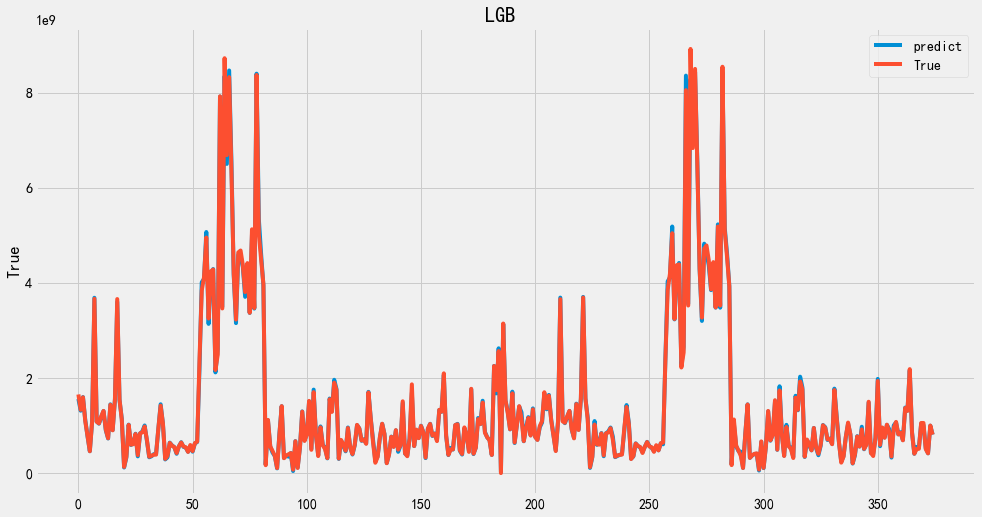

In [73]:
# comparison of results

x_test['predict'] = pred 
x_test['True'] = y_test

# store
result_set['LGBresult'] = pred

plt.figure(figsize=(15,8)) 
plt.title('LGB ')
sns.lineplot(data = x_test,x = range(375),y = x_test['predict'],label = 'predict')
sns.lineplot(data = x_test,x = range(375),y = x_test['True'],label = 'True')
plt.legend(loc='best')
plt.show()

In [74]:
# store
result_set

,LRresult,RFresult,MLPresult,LGBresult
0,1.548473e+09,1.578383e+09,1.541068e+09,1.561838e+09
1,1.279134e+09,1.290737e+09,1.269044e+09,1.314134e+09
2,1.600447e+09,1.584435e+09,1.590749e+09,1.600043e+09
3,1.160362e+09,1.150376e+09,1.146840e+09,1.119630e+09
4,8.238721e+08,8.182958e+08,8.160087e+08,7.753368e+08
...,...,...,...,...
370,8.694195e+08,1.040896e+09,1.056438e+09,1.008572e+09
371,3.416218e+08,5.220634e+08,5.263721e+08,5.292320e+08
372,2.553143e+08,4.315136e+08,4.415300e+08,4.177780e+08
373,7.783787e+08,1.011331e+09,9.676617e+08,9.988967e+08


In [75]:
ytest_len = y_test.shape[0]
ytest_len

375

In [76]:
# df['all_motor_vehicles'][-ytest_len:-1]

In [77]:
result_set['source_data'] = df['all_motor_vehicles'][-ytest_len:].values
result_set

,LRresult,RFresult,MLPresult,LGBresult,source_data
0,1.548473e+09,1.578383e+09,1.541068e+09,1.561838e+09,1.655477e+09
1,1.279134e+09,1.290737e+09,1.269044e+09,1.314134e+09,1.333155e+09
2,1.600447e+09,1.584435e+09,1.590749e+09,1.600043e+09,1.595675e+09
3,1.160362e+09,1.150376e+09,1.146840e+09,1.119630e+09,1.096376e+09
4,8.238721e+08,8.182958e+08,8.160087e+08,7.753368e+08,7.752343e+08
...,...,...,...,...,...
370,8.694195e+08,1.040896e+09,1.056438e+09,1.008572e+09,1.055627e+09
371,3.416218e+08,5.220634e+08,5.263721e+08,5.292320e+08,5.072792e+08
372,2.553143e+08,4.315136e+08,4.415300e+08,4.177780e+08,4.169537e+08
373,7.783787e+08,1.011331e+09,9.676617e+08,9.988967e+08,1.001045e+09


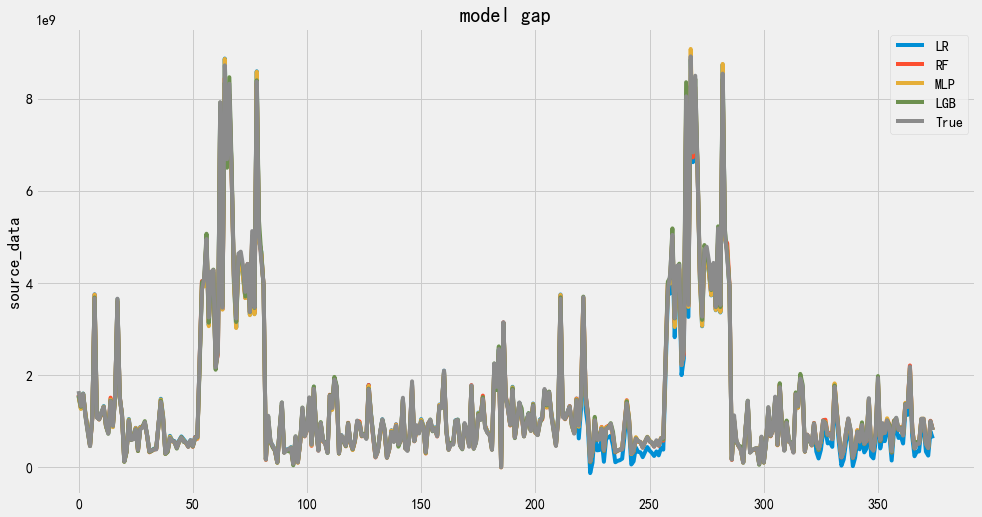

In [78]:
plt.figure(figsize=(15,8)) 
plt.title('model gap')
sns.lineplot(data = result_set,x = range(375),y = result_set['LRresult'],label = 'LR')
sns.lineplot(data = result_set,x = range(375),y = result_set['RFresult'],label = 'RF')
sns.lineplot(data = result_set,x = range(375),y = result_set['MLPresult'],label = 'MLP')
sns.lineplot(data = result_set,x = range(375),y = result_set['LGBresult'],label = 'LGB')
sns.lineplot(data = result_set,x = range(375),y = result_set['source_data'],label = 'True')
plt.legend(loc='best')
plt.show()

In [79]:
def result_map(LRresult,RFresult,MLPresult,LGBresult):
    return (result_set + RFresult + MLPresult + LGBresult).mean()

In [80]:
# result_set[['LRresult','RFresult','MLPresult','LGBresult']].mean(axis = 1)

In [81]:
result_set['result_mean'] = result_set[['LRresult','RFresult','MLPresult','LGBresult']].mean(axis = 1)
result_set

,LRresult,RFresult,MLPresult,LGBresult,source_data,result_mean
0,1.548473e+09,1.578383e+09,1.541068e+09,1.561838e+09,1.655477e+09,1.557440e+09
1,1.279134e+09,1.290737e+09,1.269044e+09,1.314134e+09,1.333155e+09,1.288262e+09
2,1.600447e+09,1.584435e+09,1.590749e+09,1.600043e+09,1.595675e+09,1.593919e+09
3,1.160362e+09,1.150376e+09,1.146840e+09,1.119630e+09,1.096376e+09,1.144302e+09
4,8.238721e+08,8.182958e+08,8.160087e+08,7.753368e+08,7.752343e+08,8.083783e+08
...,...,...,...,...,...,...
370,8.694195e+08,1.040896e+09,1.056438e+09,1.008572e+09,1.055627e+09,9.938314e+08
371,3.416218e+08,5.220634e+08,5.263721e+08,5.292320e+08,5.072792e+08,4.798223e+08
372,2.553143e+08,4.315136e+08,4.415300e+08,4.177780e+08,4.169537e+08,3.865339e+08
373,7.783787e+08,1.011331e+09,9.676617e+08,9.988967e+08,1.001045e+09,9.390670e+08


In [82]:
# compute R2 
mse = mean_squared_error(result_set['result_mean'],y_test)
mae = mean_absolute_error(result_set['result_mean'],y_test)
r2 = r2_score(result_set['result_mean'],y_test)
print('mean_model r2:',round(r2,5))
print('mean_model mse:',round(mse,5))
print('mean_model mae:',round(mae,5))

mean_model r2: 0.99865
mean_model mse: 3601061829757078.0
mean_model mae: 40264719.00505


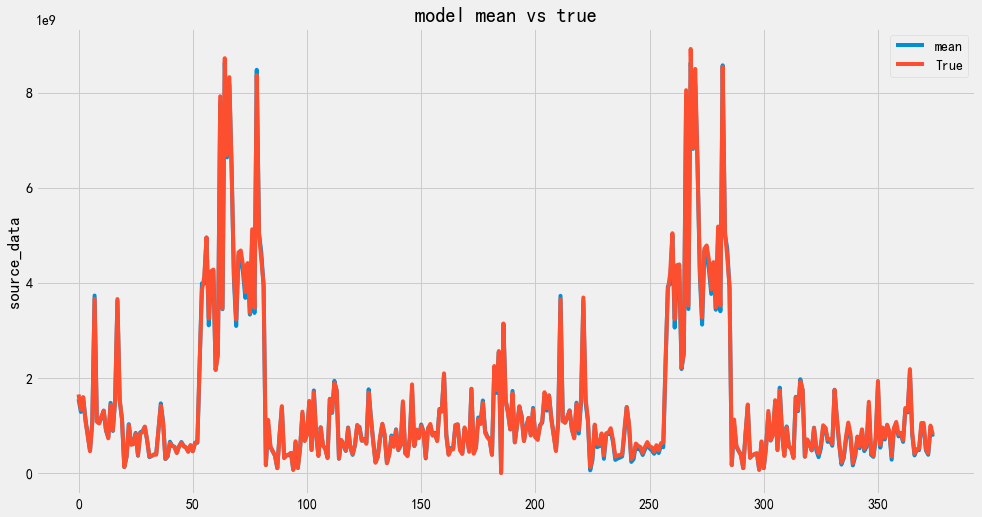

In [83]:
plt.figure(figsize=(15,8)) 
plt.title('model mean vs true')
sns.lineplot(data = result_set,x = range(375),y = result_set['result_mean'],label = 'mean')
sns.lineplot(data = result_set,x = range(375),y = result_set['source_data'],label = 'True')
plt.legend(loc='best')
plt.show()

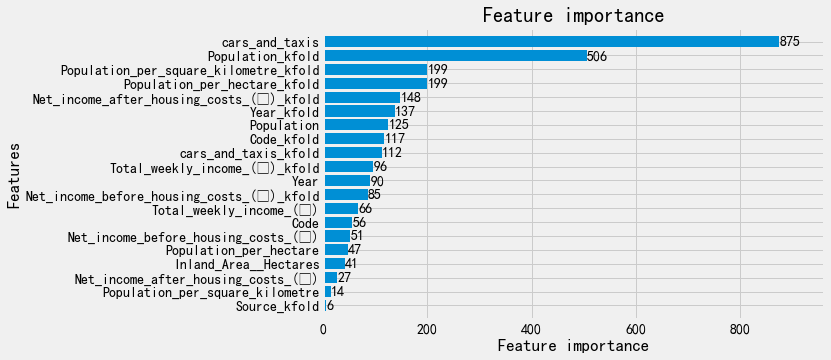

In [84]:
# Feature importance
# plot_importance；Use plot importance to plot the importance of each feature
from lightgbm import plot_importance
import lightgbm as lgb
model = lgb.LGBMRegressor()
model = model.fit(x_train,y_train)
fig,ax = plt.subplots(figsize=(8,5))
plot_importance(model,
                height=.8,
                ax=ax,
                max_num_features = 20
               )
plt.show()

In [85]:
# plot_importance()